1838 - 1839

# Regression with an Insurance Dataset

## Data

### This dataset contains 2Lk+ and 20 features with a mix of categorical, numerical, and text data. It includes missing values, incorrect data types, and skewed distributions to mimic the complexities faced in real-world datasets. The target variable for prediction is the "Premium Amount".

### Features:
1. Age: Age of the insured individual (Numerical)
2. Gender: Gender of the insured individual (Categorical: Male, Female)
3. Annual Income: Annual income of the insured individual (Numerical, skewed)
4. Marital Status: Marital status of the insured individual (Categorical: Single, Married, Divorced)
5. Number of Dependents: Number of dependents (Numerical, with missing values)
6. Education Level: Highest education level attained (Categorical: High School, Bachelor's, Master's, PhD)
7. Occupation: Occupation of the insured individual (Categorical: Employed, Self-Employed, Unemployed)
8. Health Score: A score representing the health status (Numerical, skewed)
9. Location: Type of location (Categorical: Urban, Suburban, Rural)
10. Policy Type: Type of insurance policy (Categorical: Basic, Comprehensive, Premium)
11. Previous Claims: Number of previous claims made (Numerical, with outliers)
12. Vehicle Age: Age of the vehicle insured (Numerical)
13. Credit Score: Credit score of the insured individual (Numerical, with missing values)
14. Insurance Duration: Duration of the insurance policy (Numerical, in years)
15. Premium Amount: Target variable representing the insurance premium amount (Numerical, skewed)
16. Policy Start Date: Start date of the insurance policy (Text, improperly formatted)
17. Customer Feedback: Short feedback comments from customers (Text)
18. Smoking Status: Smoking status of the insured individual (Categorical: Yes, No)
19. Exercise Frequency: Frequency of exercise (Categorical: Daily, Weekly, Monthly, Rarely)
20. Property Type: Type of property owned (Categorical: House, Apartment, Condo)

### Data Characteristics

    Missing Values: Certain features contain missing values to simulate real-world data collection issues.
    Incorrect Data Types: Some fields are intentionally set to incorrect data types to practice data cleaning.
    Skewed Distributions: Numerical features like Annual Income and Premium Amount have skewed distributions, which can be addressed through transformations.


## Base imports

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.cm import viridis
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import math

from scipy.signal import find_peaks
from scipy.stats import skew 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from sklearn.model_selection import KFold


## Data analysis

### Reading data

In [2]:
train = pd.read_csv('train.csv',index_col=[0])
test = pd.read_csv('test.csv',index_col=[0])
sample = pd.read_csv('sample_submission.csv')
data = pd.concat([train, test], axis=0,ignore_index=True)

# Verify shapes
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
#data.info()

Train Data Shape: (1200000, 20)
Test Data Shape: (800000, 19)


In [3]:
# Display sample data
print("Training Dataset: \n")
display(train.head())
print('\n')
print("Test Dataset: \n")
display(test.head())

Training Dataset: 



,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0




Test Dataset: 



,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
id,,,,,,,,,,,,,,,,,,,
1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [4]:
# Display information for the training dataset
print("Training Dataset Information: \n")
train_info = train.info()
display(train_info)
print('\n')
# Display information for the test dataset
print("Test Dataset Information: \n")
test_info = test.info()
display(test_info)

Training Dataset Information: 

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy 

None



Test Dataset Information: 

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 1200000 to 1999999
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Age                   787511 non-null  float64
 1   Gender                800000 non-null  object 
 2   Annual Income         770140 non-null  float64
 3   Marital Status        787664 non-null  object 
 4   Number of Dependents  726870 non-null  float64
 5   Education Level       800000 non-null  object 
 6   Occupation            560875 non-null  object 
 7   Health Score          750551 non-null  float64
 8   Location              800000 non-null  object 
 9   Policy Type           800000 non-null  object 
 10  Previous Claims       557198 non-null  float64
 11  Vehicle Age           799997 non-null  float64
 12  Credit Score          708549 non-null  float64
 13  Insurance Duration    799998 non-null  float64
 14  Policy Start Date   

None

### Handling Missing Values

#### Overview and Heatmaps

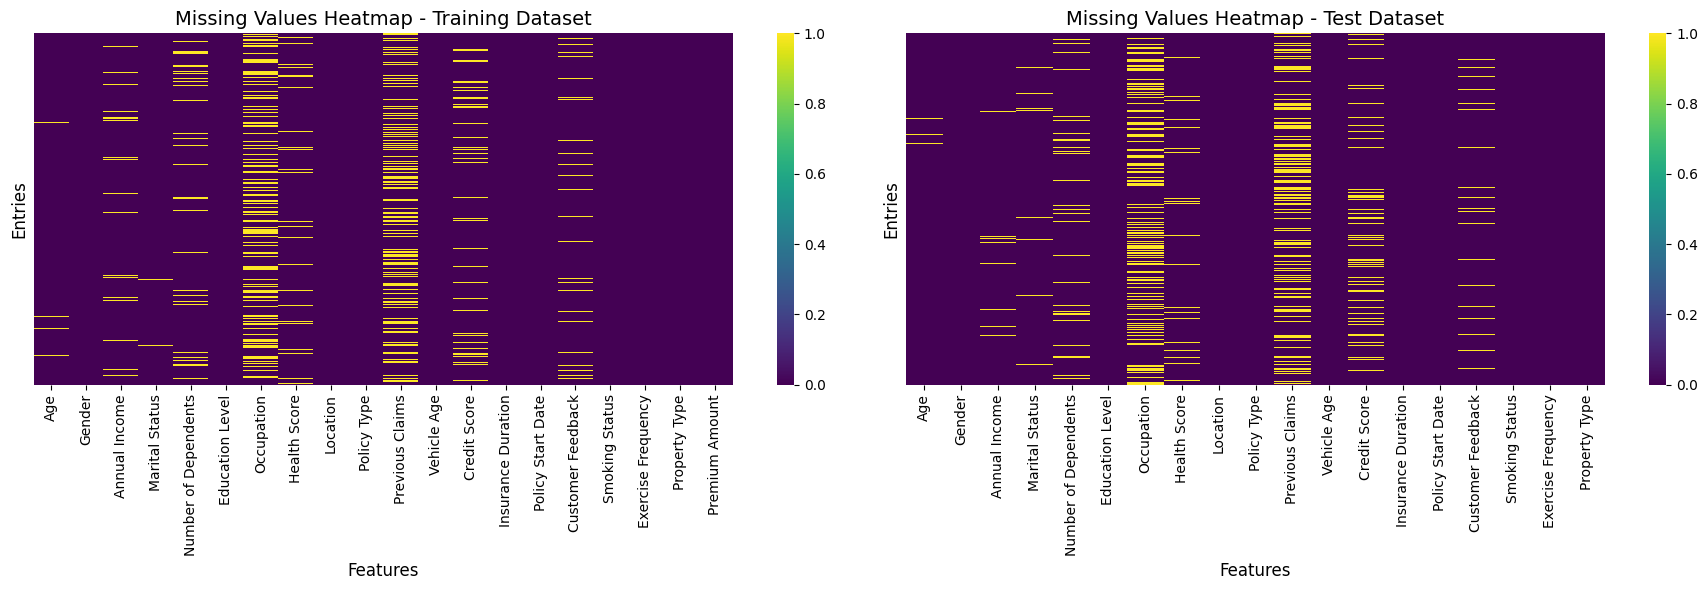

In [5]:
# Check for missing values in the datasets
missing_train = train.isnull()
missing_test = test.isnull()

# Create a single figure with subplots for both datasets
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap for missing values in the training dataset
sns.heatmap(missing_train, cmap='viridis', cbar=True, yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Values Heatmap - Training Dataset', fontsize=14)
axes[0].set_xlabel('Features', fontsize=12)
axes[0].set_ylabel('Entries', fontsize=12)

# Heatmap for missing values in the test dataset
sns.heatmap(missing_test, cmap='viridis', cbar=True, yticklabels=False, ax=axes[1])
axes[1].set_title('Missing Values Heatmap - Test Dataset', fontsize=14)
axes[1].set_xlabel('Features', fontsize=12)
axes[1].set_ylabel('Entries', fontsize=12)

plt.tight_layout()
plt.show()

##### Insights from Missing Values Heatmaps:

    Training Dataset:
        Several features in the training dataset have missing values, as indicated by the yellow streaks in the heatmap.
        Features such as Number of Dependents, Occupation, Previous Claims, and Credit Score have a relatively high number of missing values.
        Some columns, such as Policy Start Date and Gender, seem to have no missing values as indicated by their continuous dark bands.

    Test Dataset:
        The test dataset also has missing values, with patterns similar to the training dataset.
        Features like Previous Claims, Occupation, and Number of Dependents show significant missing values, aligning with the training dataset's pattern.
        No additional features have missing values compared to the training dataset, which ensures consistency between the datasets.

    Dataset Comparison:
        The distribution of missing values appears consistent across both the training and test datasets, implying similar data collection or preprocessing methods were used.
        The percentage of missing values for features like Credit Score and Previous Claims might influence their impact on predictive models.



In [6]:
# Function to calculate missing values, percentages, and data types
def missing_values_table(df):
    missing_count = df.isnull().sum()
    missing_percentage = 100 * missing_count / len(df)
    data_types = df.dtypes
    return pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage (%)': missing_percentage,
        'Data Type': data_types
    })

# Create tables for train and test datasets
train_missing_table = missing_values_table(train)
test_missing_table = missing_values_table(test)

# Display the tables
print("Missing Values Table - Training Dataset:\n")
display(train_missing_table[train_missing_table['Missing Values'] > 0])  # Display only features with missing values
print("\n")

print("Missing Values Table - Test Dataset:\n")
display(test_missing_table[test_missing_table['Missing Values'] > 0])  

Missing Values Table - Training Dataset:



,Missing Values,Percentage (%),Data Type
Age,18705,1.558750,float64
Annual Income,44949,3.745750,float64
Marital Status,18529,1.544083,object
Number of Dependents,109672,9.139333,float64
Occupation,358075,29.839583,object
Health Score,74076,6.173000,float64
Previous Claims,364029,30.335750,float64
Vehicle Age,6,0.000500,float64
Credit Score,137882,11.490167,float64
Insurance Duration,1,0.000083,float64




Missing Values Table - Test Dataset:



,Missing Values,Percentage (%),Data Type
Age,12489,1.561125,float64
Annual Income,29860,3.732500,float64
Marital Status,12336,1.542000,object
Number of Dependents,73130,9.141250,float64
Occupation,239125,29.890625,object
Health Score,49449,6.181125,float64
Previous Claims,242802,30.350250,float64
Vehicle Age,3,0.000375,float64
Credit Score,91451,11.431375,float64
Insurance Duration,2,0.000250,float64


##### Observational Insights from Missing Values Table:
Training Dataset:

    Columns with High Missing Values:
        Occupation (29.84%) and Previous Claims (30.34%) have the highest percentage of missing values. These features might significantly impact the dataset's completeness and require careful handling.
        Credit Score (11.49%) and Number of Dependents (9.14%) also have notable missing percentages.

    Columns with Moderate Missing Values:
        Features such as Health Score (6.17%) and Customer Feedback (6.49%) have moderate levels of missing values.

    Columns with Minimal Missing Values:
        Features like Vehicle Age (0.0005%) and Insurance Duration (0.00008%) have very few missing values, which can be easily imputed without much impact.

    Data Types:
        Features with missing values include both numerical (float64) and categorical (object) data types, indicating the need for distinct imputation strategies.

Test Dataset:

    Columns with High Missing Values:
        Similar to the training dataset, Occupation (29.89%) and Previous Claims (30.35%) exhibit the highest percentage of missing values.
        Credit Score (11.43%) and Number of Dependents (9.14%) also show significant missingness.

    Columns with Moderate Missing Values:
        Features such as Health Score (6.18%) and Customer Feedback (6.53%) align closely with the training dataset in terms of missing values.

    Columns with Minimal Missing Values:
        Features like Vehicle Age (0.000375%) and Insurance Duration (0.00025%) have minimal missing data, mirroring the training dataset.

    Consistency:
        The percentages of missing values in the test dataset are highly consistent with the training dataset, making it easier to apply uniform imputation strategies.


/tmp/ipykernel_469663/4034938057.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  train_colors = cm.get_cmap('viridis', len(train_missing))(range(len(train_missing)))
/tmp/ipykernel_469663/4034938057.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  test_colors = cm.get_cmap('viridis', len(test_missing))(range(len(test_missing)))


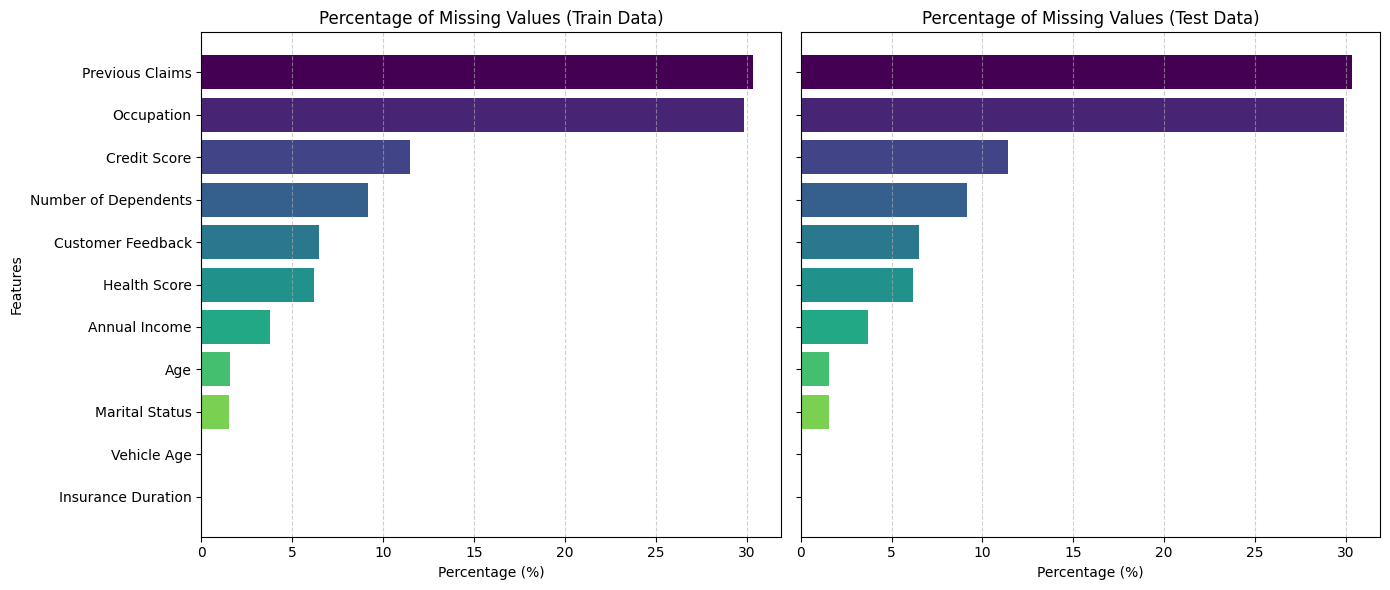

In [7]:
# Filter missing values for train and test datasets
train_missing = train_missing_table[train_missing_table['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)
test_missing = test_missing_table[test_missing_table['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Bar plot for train dataset
train_colors = cm.get_cmap('viridis', len(train_missing))(range(len(train_missing)))
axes[0].barh(train_missing.index, train_missing['Percentage (%)'], color=train_colors)
axes[0].set_title('Percentage of Missing Values (Train Data)', fontsize=12)
axes[0].set_xlabel('Percentage (%)', fontsize=10)
axes[0].set_ylabel('Features', fontsize=10)
axes[0].grid(axis='x', linestyle='--', alpha=0.6)
axes[0].invert_yaxis()  

# Bar plot for test dataset
test_colors = cm.get_cmap('viridis', len(test_missing))(range(len(test_missing)))
axes[1].barh(test_missing.index, test_missing['Percentage (%)'], color=test_colors)
axes[1].set_title('Percentage of Missing Values (Test Data)', fontsize=12)
axes[1].set_xlabel('Percentage (%)', fontsize=10)
axes[1].grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

##### Key Observations:

    Consistency Across Datasets: The percentage of missing values in features is highly consistent between the training and test datasets, simplifying the imputation strategy.
    Critical Features: High missing percentages in key features like Previous Claims and Occupation could impact model performance significantly if not addressed carefully.
    Potential Strategies:
        Imputation: Use median or mean values for numerical features like Credit Score and Number of Dependents. For categorical features like Occupation, use the mode or "Unknown".



In [8]:
# Filter only features with missing values in the training dataset
features_with_missing = train_missing_table[train_missing_table['Missing Values'] > 0].index.tolist()

def analyze_nan_with_target_filtered(df, target_column, features):
    missing_analysis = {}
    
    for col in features:
        # Split the data into missing and non-missing subsets for the column
        missing_mask = df[col].isnull()
        non_missing_mask = ~missing_mask
        
        # Calculate statistics for Premium Amount
        stats = {
            "Missing Count": missing_mask.sum(),
            "Non-Missing Count": non_missing_mask.sum(),
            "Mean (Missing)": df.loc[missing_mask, target_column].mean(),
            "Mean (Non-Missing)": df.loc[non_missing_mask, target_column].mean(),
            "Median (Missing)": df.loc[missing_mask, target_column].median(),
            "Median (Non-Missing)": df.loc[non_missing_mask, target_column].median(),
            "Std Dev (Missing)": df.loc[missing_mask, target_column].std(),
            "Std Dev (Non-Missing)": df.loc[non_missing_mask, target_column].std(),
        }
        
        missing_analysis[col] = stats
    
    return pd.DataFrame(missing_analysis).T

# Perform the analysis for only features with missing values
missing_vs_premium_filtered = analyze_nan_with_target_filtered(train, "Premium Amount", features_with_missing)

# Display the results
print("Analysis of Missing Values with Target (Premium Amount):\n")
display(missing_vs_premium_filtered)

Analysis of Missing Values with Target (Premium Amount):



,Missing Count,Non-Missing Count,Mean (Missing),Mean (Non-Missing),Median (Missing),Median (Non-Missing),Std Dev (Missing),Std Dev (Non-Missing)
Age,18705.0,1181295.0,1096.003689,1102.648396,873.0,872.0,862.234397,865.042527
Annual Income,44949.0,1155051.0,930.200605,1109.251625,556.0,882.0,959.098967,860.432015
Marital Status,18529.0,1181471.0,1217.871067,1100.736161,1001.0,871.0,904.286237,864.246334
Number of Dependents,109672.0,1090328.0,1126.441571,1100.141137,892.0,871.0,885.171044,862.907498
Occupation,358075.0,841925.0,1093.320969,1106.467773,861.0,876.0,859.637058,867.239987
Health Score,74076.0,1125924.0,1158.043172,1098.893513,930.0,867.0,782.759101,870.013254
Previous Claims,364029.0,835971.0,1076.944592,1113.692608,845.0,882.0,852.091240,870.324942
Vehicle Age,6.0,1199994.0,1197.833333,1102.544345,935.5,872.0,855.199022,864.999234
Credit Score,137882.0,1062118.0,1085.615773,1104.742516,845.0,874.0,874.343015,863.754490
Insurance Duration,1.0,1199999.0,1044.000000,1102.544870,1044.0,872.0,NaN,864.999218


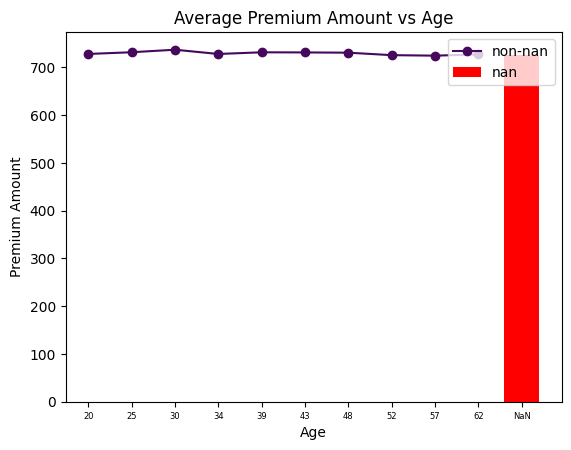

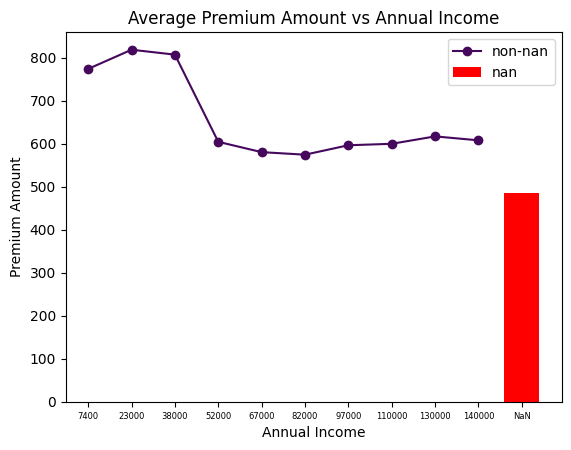

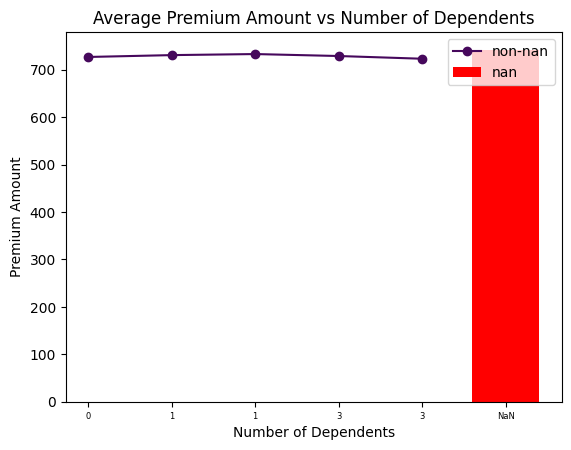

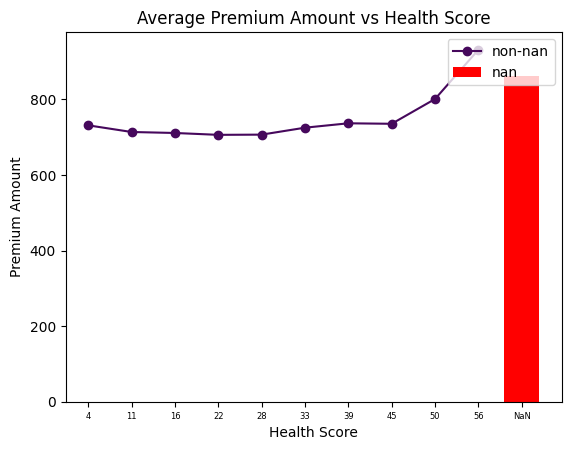

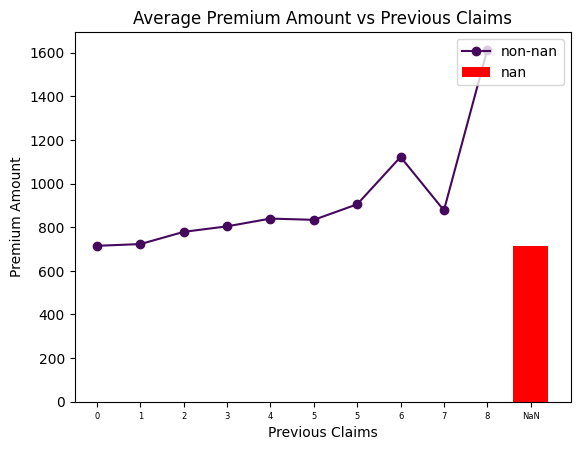

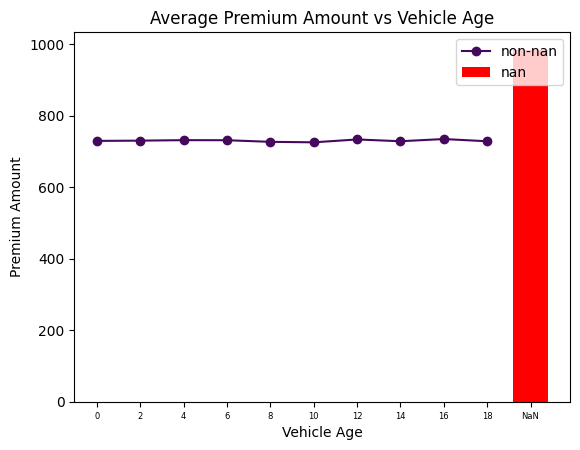

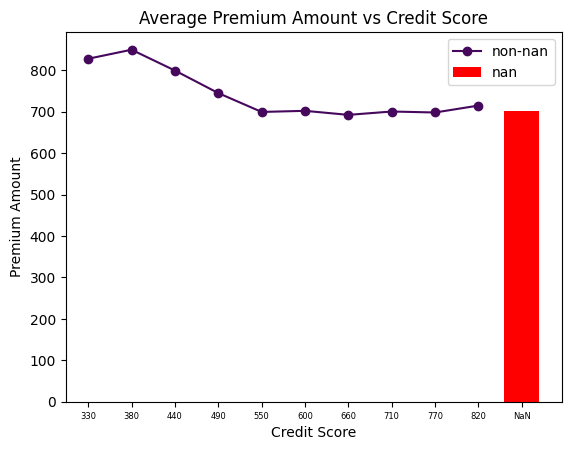

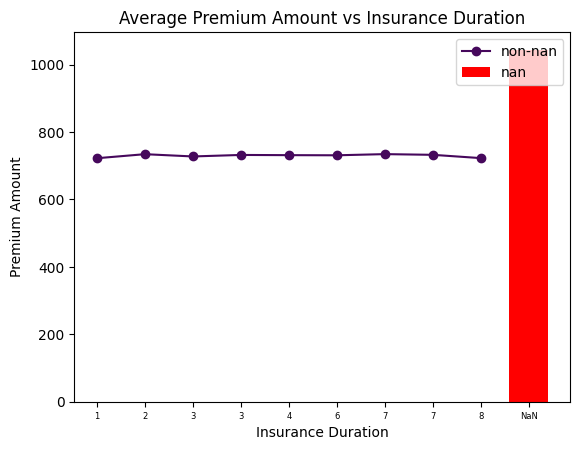

In [9]:
# List of float-type columns with missing values
float_missing_columns = ['Age', 'Annual Income', 'Number of Dependents', 
                         'Health Score', 'Previous Claims', 'Vehicle Age', 
                         'Credit Score', 'Insurance Duration']

for column in float_missing_columns:
    # Drop NaN values for binning, but retain the NaN group separately
    valid_data = train[column].dropna()
    bins = 10

    # Bin the non-NaN values
    binned_data = pd.cut(valid_data, bins)
    df = pd.DataFrame({
        column: binned_data,
        'Premium Amount': train.loc[valid_data.index, 'Premium Amount']
    })
    
    # Group by the binned column and calculate mean Premium Amount
    grouped = df.groupby(column, observed=True, dropna=False).agg(
        lambda x: np.expm1(np.log1p(x).mean())
    ).reset_index()
    
    # Add the NaN group separately
    nan_group_mean = np.expm1(np.log1p(train.loc[train[column].isnull(), 'Premium Amount']).mean())
    nan_group = pd.DataFrame({column: ['NaN'], 'Premium Amount': [nan_group_mean]})
    
    # Concatenate the NaN group with the grouped data
    grouped = pd.concat([grouped, nan_group], ignore_index=True)
    
    def label(x):
        if isinstance(x, float) or x == 'NaN':
            return x
        x = x.mid  # Get the midpoint of the interval
        s = int(np.floor(np.log10(x)))
        return int(round(x, -s+1))

    # Select the viridis color
    viridis_colors = viridis(range(256))
    line_color = viridis_colors[5]

    # Plot the non-NaN bins as a line plot
    plt.plot(grouped[:-1]['Premium Amount'], marker='o', color=line_color, label='non-nan')

    # Plot the NaN bin as a bar
    plt.bar(len(grouped) - 1, grouped.iloc[-1]['Premium Amount'], color='red', label='nan')

    # Set x-ticks and labels
    plt.xticks(range(len(grouped)), labels=grouped[column].apply(label), fontsize=6)
    plt.title(f'Average Premium Amount vs {column}')
    plt.xlabel(column)
    plt.ylabel('Premium Amount')
    plt.legend(loc='upper right')
    plt.show()

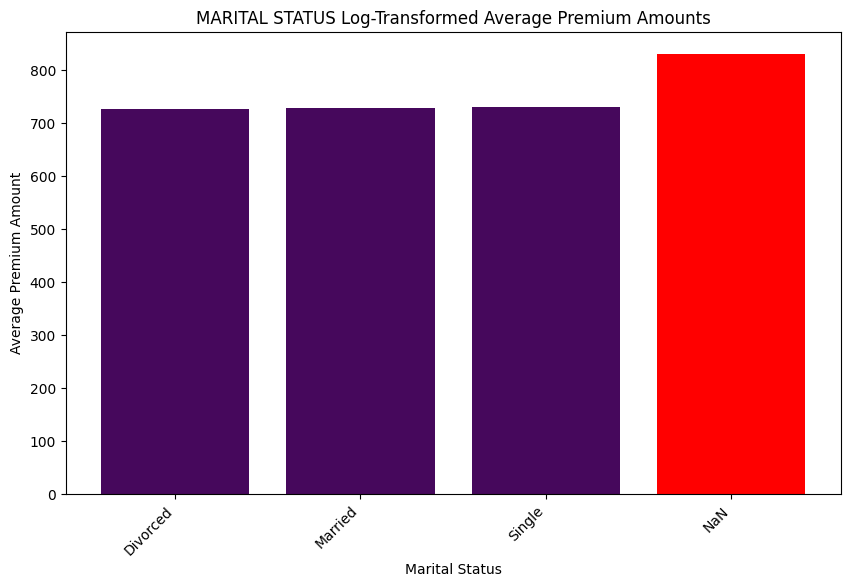

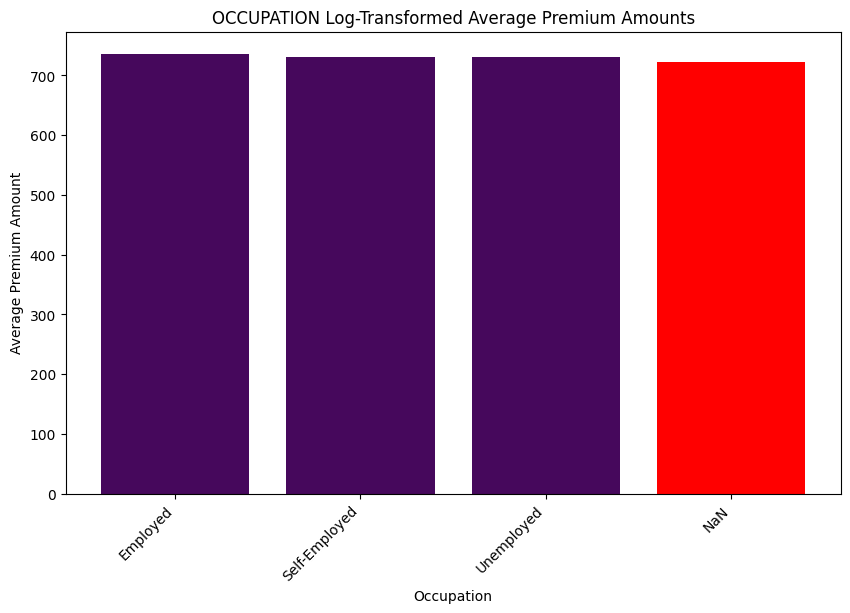

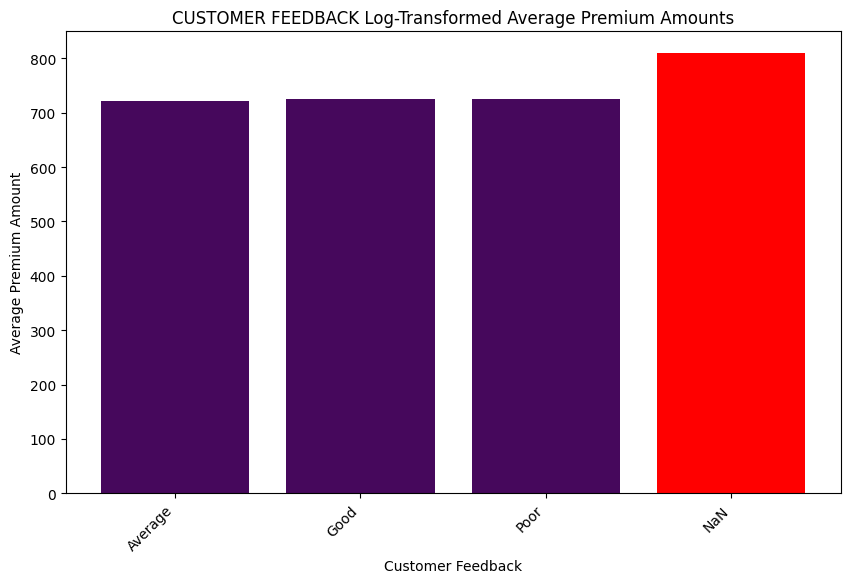

In [10]:
# List of object-type columns with missing values
object_missing_columns = ['Marital Status', 'Occupation', 'Customer Feedback']

for column in object_missing_columns:
    # Group by the column and calculate the average log-transformed Premium Amount
    grouped = train.groupby(column)['Premium Amount'].agg(
        lambda x: np.expm1(np.log1p(x).mean())  # Use log-transform to calculate mean
    ).reset_index()
    
    # Calculate the average log-transformed Premium Amount for missing (NaN) values
    nan_group_mean = np.expm1(np.log1p(train.loc[train[column].isnull(), 'Premium Amount']).mean())
    
    # Add a row for the NaN group
    nan_group = pd.DataFrame({column: ['NaN'], 'Premium Amount': [nan_group_mean]})
    grouped = pd.concat([grouped, nan_group], ignore_index=True)
    
    # Use viridis color palette for the bars
    viridis_colors = viridis(range(256))  
    bar_colors = [viridis_colors[5]] * (len(grouped) - 1) + ['red']  

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(grouped[column].astype(str), grouped['Premium Amount'], color=bar_colors)
    
    # Set labels and title
    plt.title(f'{column.upper()} Log-Transformed Average Premium Amounts')
    plt.ylabel('Average Premium Amount')
    plt.xlabel(column)
    plt.xticks(rotation=45, ha='right')  
    plt.show()

#### Filling Missing Values in Numeric Columns

In [11]:
numeric_columns = train.select_dtypes(include=['number']).columns

for col in numeric_columns:
    if col in test.columns:
        # Impute missing values with -1
        train[col] = train[col].fillna(-1)
        test[col] = test[col].fillna(-1)

#### Filling Missing Values in Object Columns

In [12]:
object_columns = train.select_dtypes(include=['object']).columns
for col in object_columns:
    if col in test.columns:
        train[col] = train[col].fillna("Unknown")
        test[col] = test[col].fillna("Unknown")

In [13]:
# Verify Missing Values

print("Missing Values After Imputation - Training Dataset:")
print(train.isnull().sum())

print("\nMissing Values After Imputation - Test Dataset:")
print(test.isnull().sum())

Missing Values After Imputation - Training Dataset:
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

Missing Values After Imputation - Test Dataset:
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Po

### Target Column Extraction and Visualizing Distribution

In [14]:
target_column = (set(train.columns) - set(test.columns)).pop()

print(f"Target column: {target_column}")
print(f"Data type: {train[target_column].dtype}")

Target column: Premium Amount
Data type: float64


/tmp/ipykernel_469663/3363205978.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap("viridis")


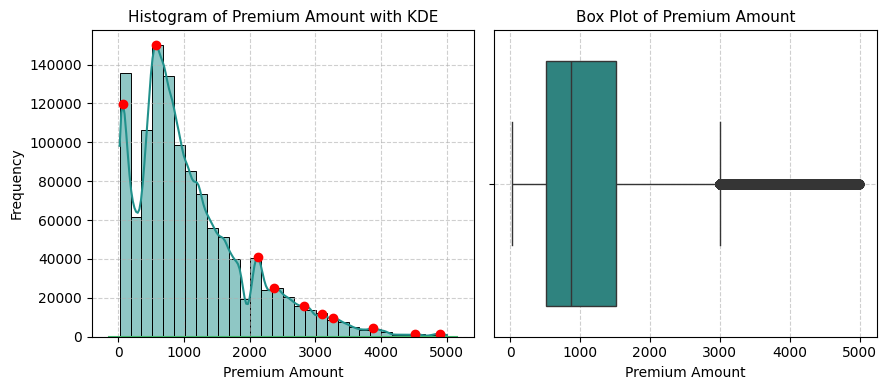

In [15]:
# Custom colormap using viridis
viridis_cmap = cm.get_cmap("viridis")

def visualize_premium_amount_with_peaks(data, feature='Premium Amount'):
    plt.figure(figsize=(9, 4))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    ax = sns.histplot(data[feature], bins=30, kde=True, color=viridis_cmap(0.5))
    plt.title(f'Histogram of {feature} with KDE', fontsize=11)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6) 

    # Extract KDE values to find peaks
    kde = sns.kdeplot(data[feature], ax=ax, color=viridis_cmap(0.7)).lines[0].get_data()
    kde_x, kde_y = kde[0], kde[1]
    peaks, _ = find_peaks(kde_y)

    # Highlight peaks
    for peak_idx in peaks:
        plt.plot(kde_x[peak_idx], kde_y[peak_idx], "ro")  # Red dots on peaks

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[feature], color=viridis_cmap(0.5))
    plt.title(f'Box Plot of {feature}', fontsize=11)
    plt.xlabel(feature, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)  
    plt.tight_layout()
    plt.show()

visualize_premium_amount_with_peaks(train, feature='Premium Amount')

    Distribution Characteristics
        The Premium Amount shows a right-skewed distribution, meaning most of the values are concentrated towards lower premiums, with fewer instances of higher premium amounts.
        The red peaks highlight the modes (local maxima), indicating clusters where specific premium amounts are more common. The highest mode appears around 1000, suggesting this is a prevalent premium value in the dataset.

    Outliers and Variability
        The box plot demonstrates that a significant number of premium values fall within a lower range, as shown by the interquartile range (IQR).
        There are many outliers present, representing higher premium amounts that lie far beyond the upper whisker of the box plot. These outliers may require further analysis to understand their nature or consider their treatment in modeling (e.g., log transformation).


### Distribution Analysis of Numerical Features

/tmp/ipykernel_469663/759331643.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap("viridis")


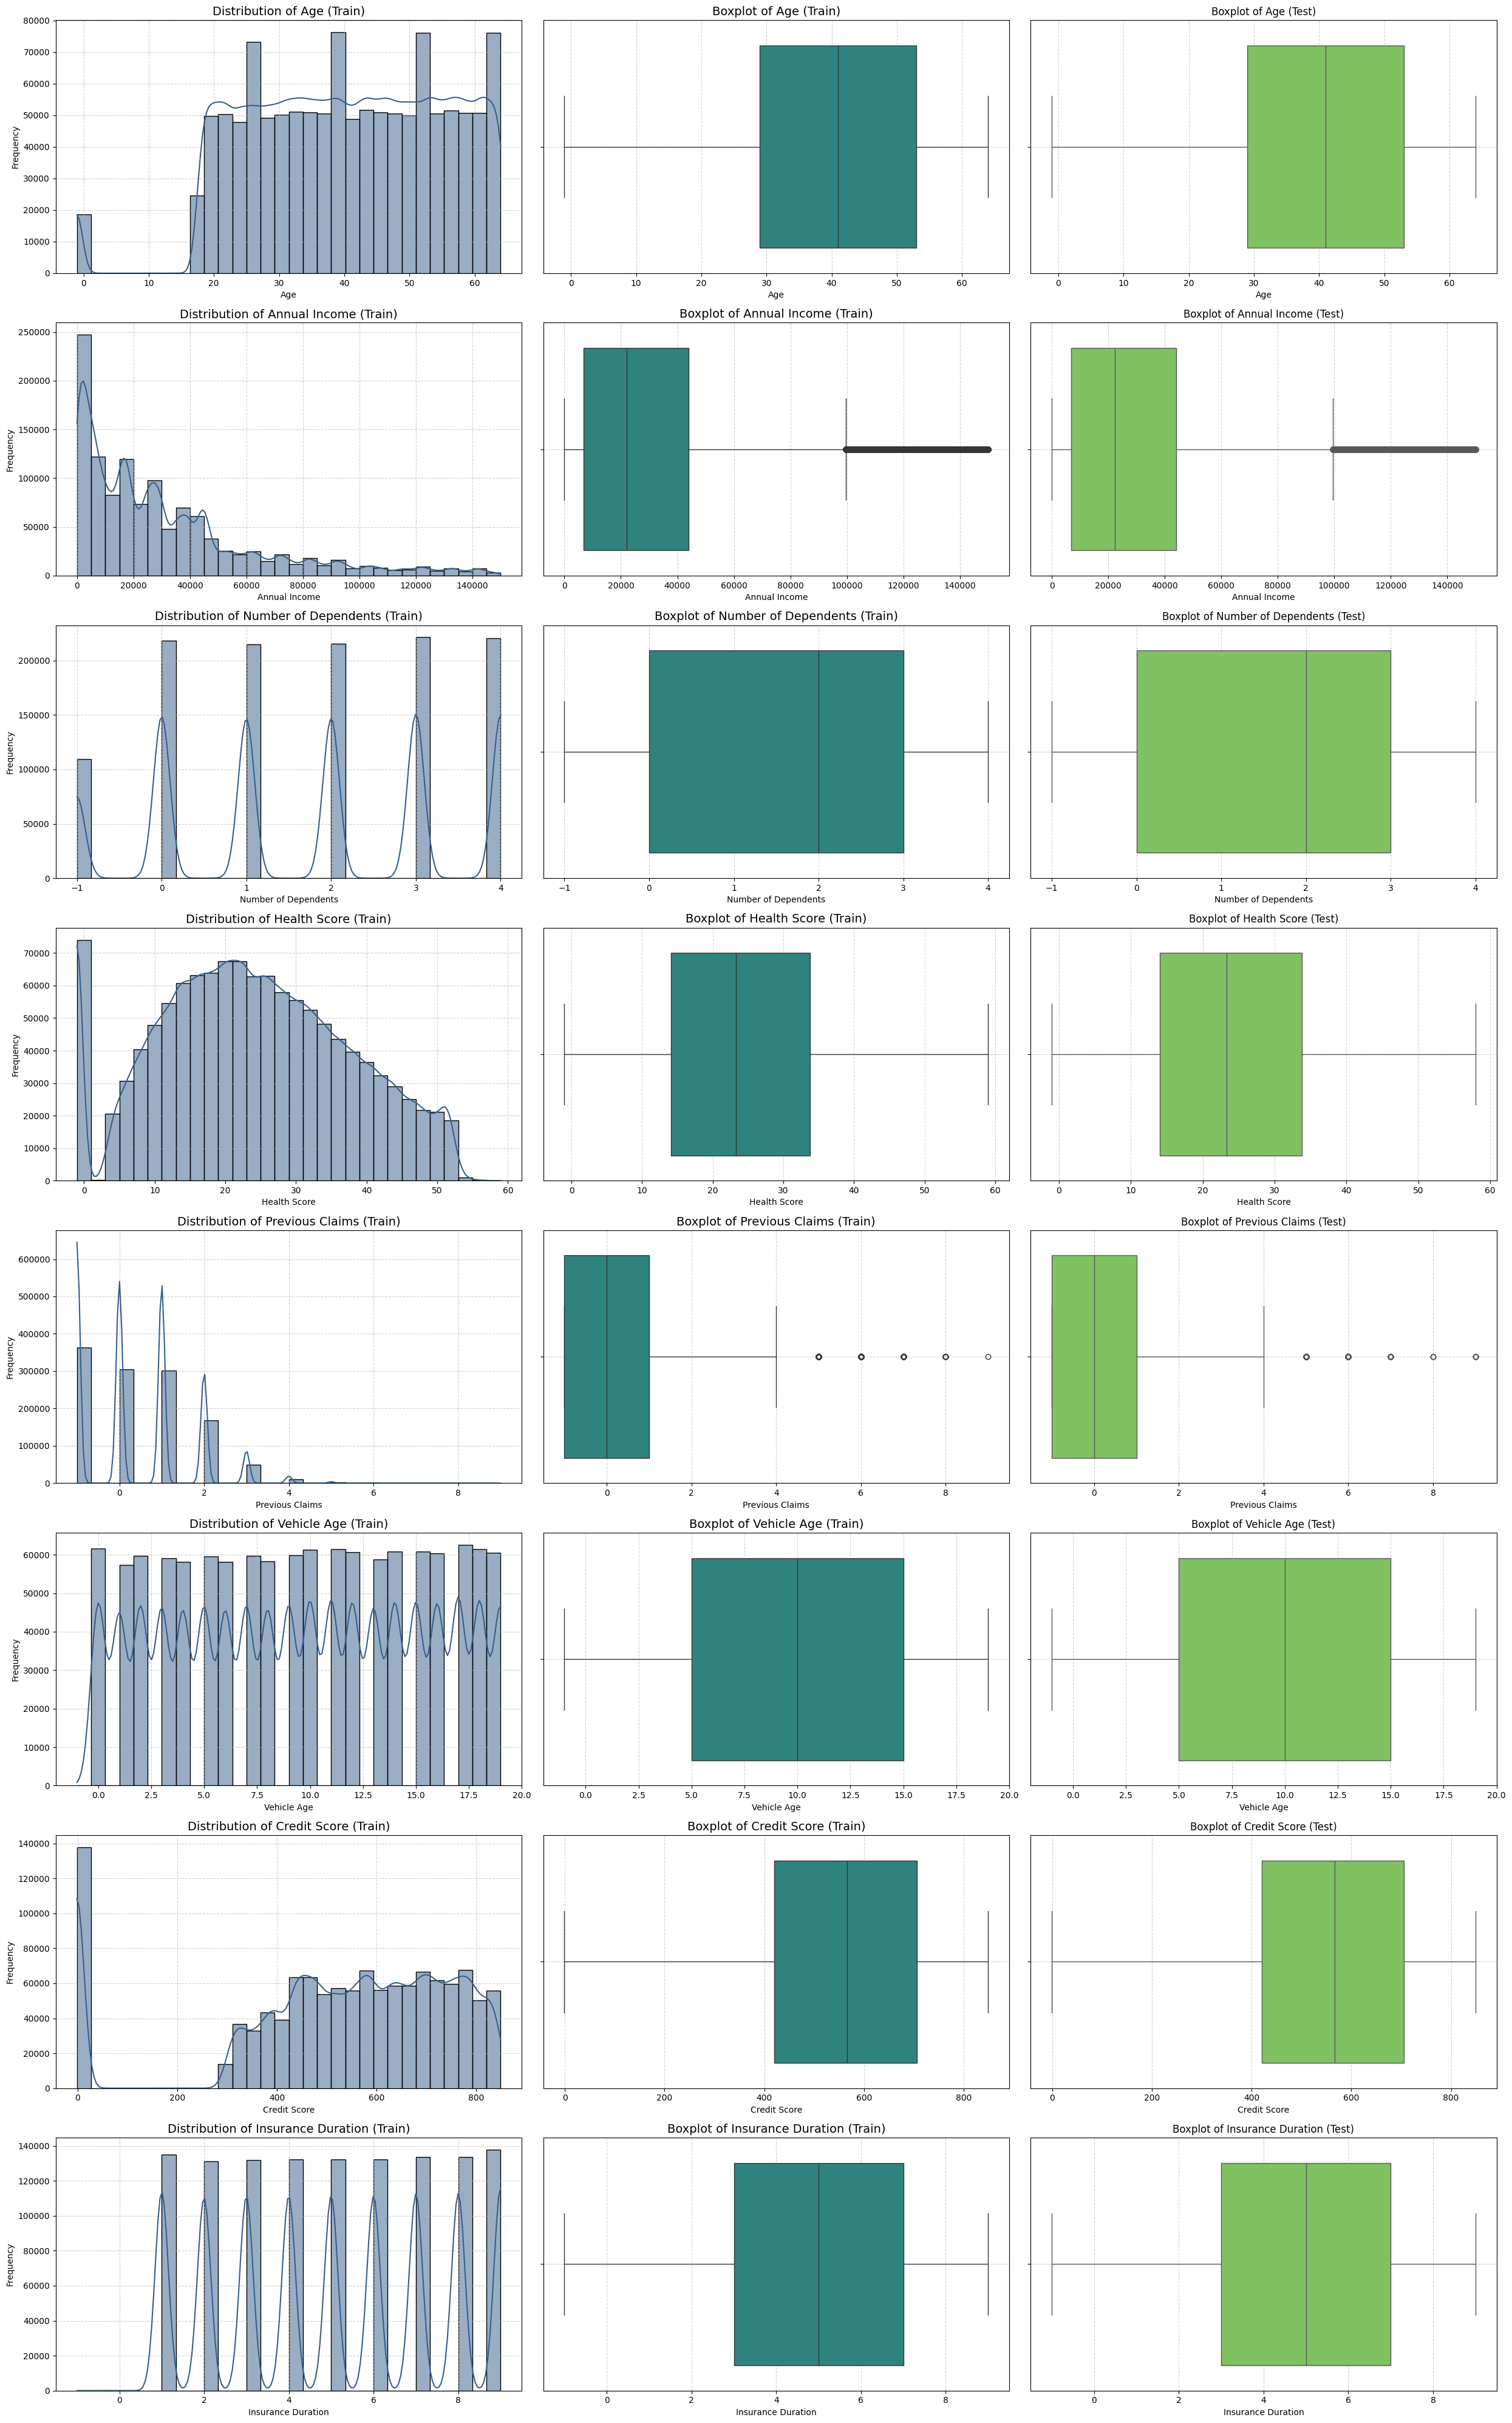

In [16]:
# Define columns to analyze
columns_to_analyze = train.select_dtypes(include=['number']).columns.drop('Premium Amount')

viridis_cmap = cm.get_cmap("viridis")
# Extract three colors from the colormap
viridis_colors = [viridis_cmap(0.3), viridis_cmap(0.5), viridis_cmap(0.8)]

fig, axes = plt.subplots(len(columns_to_analyze), 3, figsize=(25, len(columns_to_analyze) * 5))

for i, column in enumerate(columns_to_analyze):
    # Histogram for train_data
    sns.histplot(train[column], bins=30, kde=True, color=viridis_colors[0], ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column} (Train)', fontsize=14)
    axes[i, 0].set_xlabel(column, fontsize=10)
    axes[i, 0].set_ylabel('Frequency', fontsize=10)
    axes[i, 0].grid(visible=True, linestyle='--', alpha=0.6)

    # Boxplot for train_data
    sns.boxplot(x=train[column], color=viridis_colors[1], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {column} (Train)', fontsize=14)
    axes[i, 1].set_xlabel(column, fontsize=10)
    axes[i, 1].grid(visible=True, linestyle='--', alpha=0.6)

    # Boxplot for test_data
    sns.boxplot(x=test[column], color=viridis_colors[2], ax=axes[i, 2])
    axes[i, 2].set_title(f'Boxplot of {column} (Test)', fontsize=12)
    axes[i, 2].set_xlabel(column, fontsize=10)
    axes[i, 2].grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

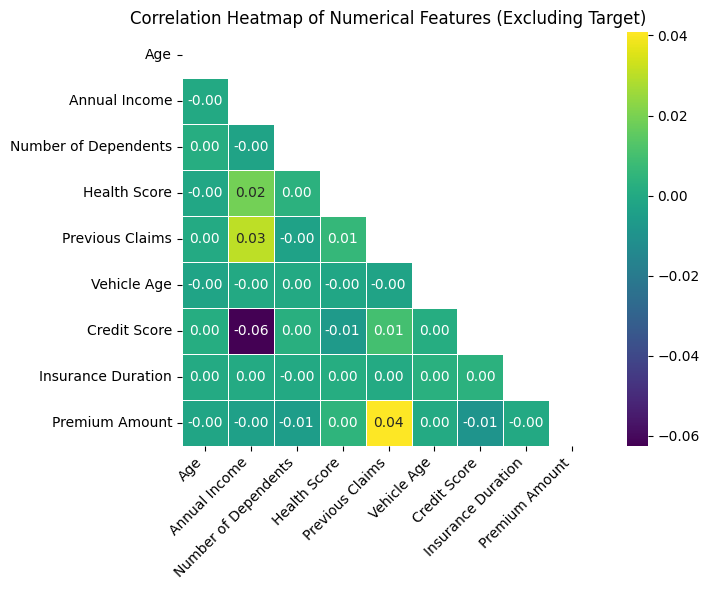

In [17]:
# Select numeric columns 
numeric_data = train.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='viridis',  
    cbar=True, 
    square=True,
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),  
    linewidths=0.5  
)

plt.title('Correlation Heatmap of Numerical Features (Excluding Target)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



Low Correlation Between Features:

    The majority of the features exhibit very low correlation values (close to 0), indicating that they are weakly related or independent.
    This suggests minimal multicollinearity, which is beneficial for model training as it reduces the risk of redundancy in predictive features.

Key Observations:

    Credit Score vs Annual Income: Shows a slightly negative correlation (-0.20), suggesting that individuals with lower income might have slightly higher credit scores or vice versa.
    Premium Amount vs Previous Claims: The correlation value is positive (0.05), indicating that individuals with higher previous claims tend to have slightly higher premium amounts.
    Health Score vs Premium Amount: A weak positive correlation (0.01) suggests minimal influence of health score on premium amount.

Premium Amount Correlation:

    Most features show minimal correlation with the target variable (Premium Amount), highlighting the potential for non-linear relationships that might require advanced modeling techniques (e.g., tree-based algorithms).



### Categorical Feature Analysis

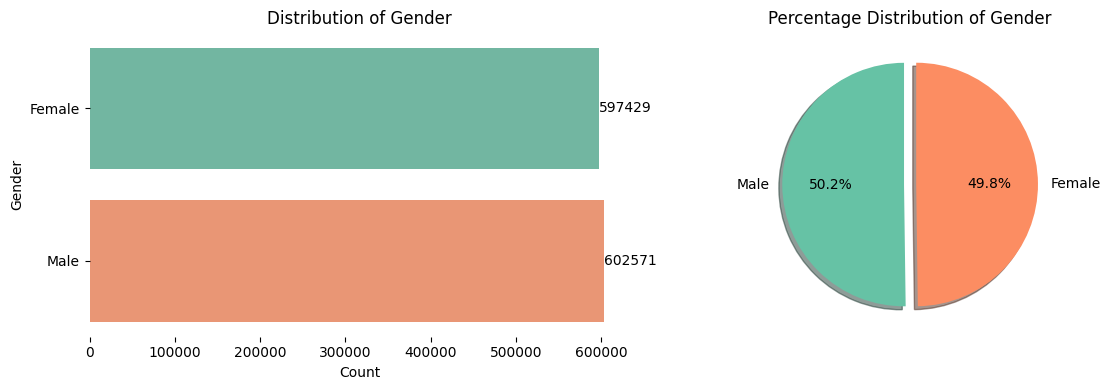

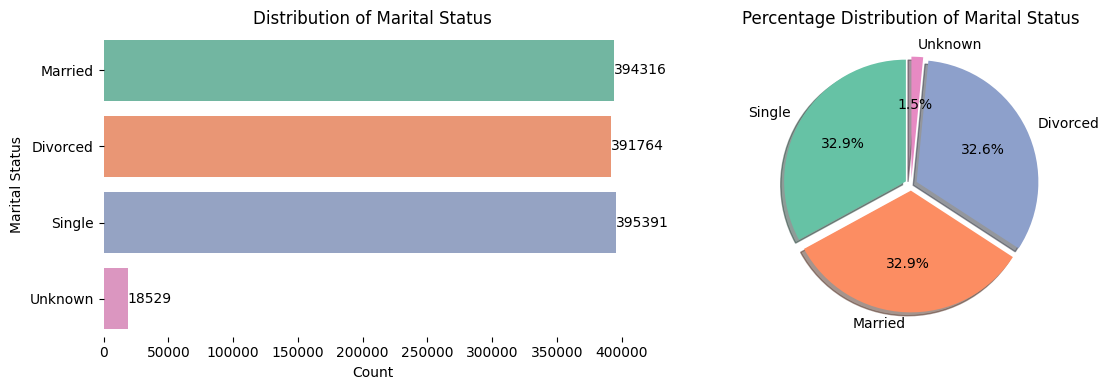

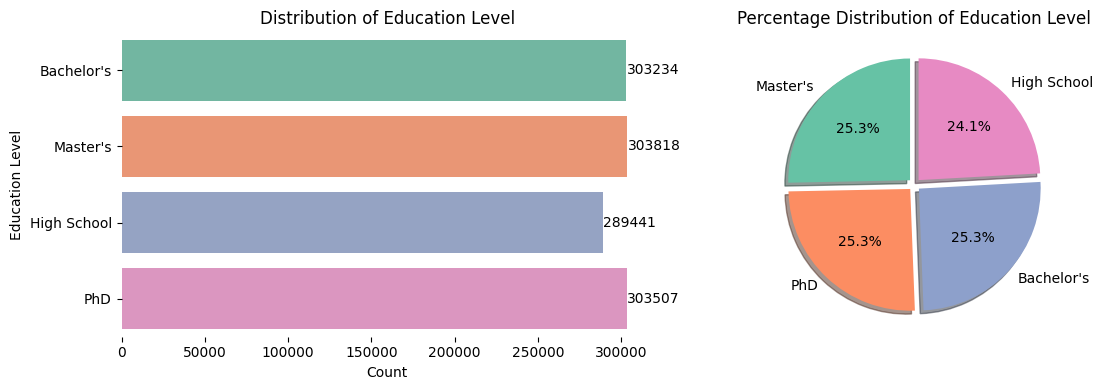

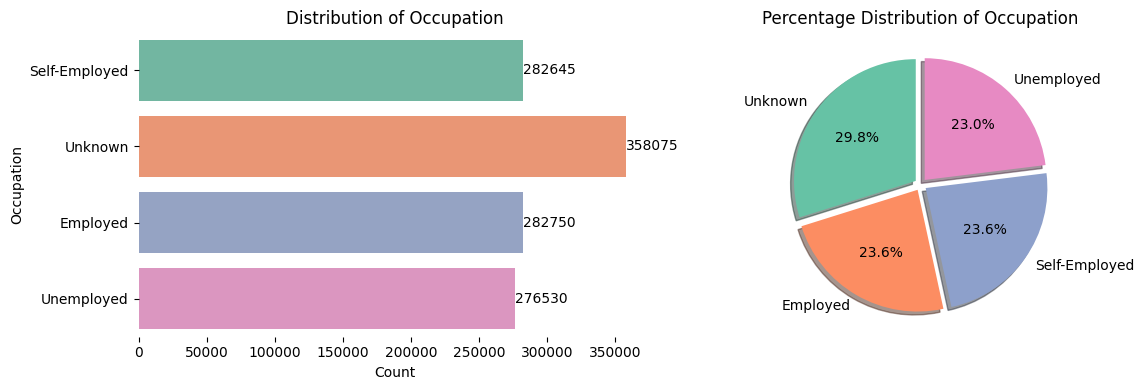

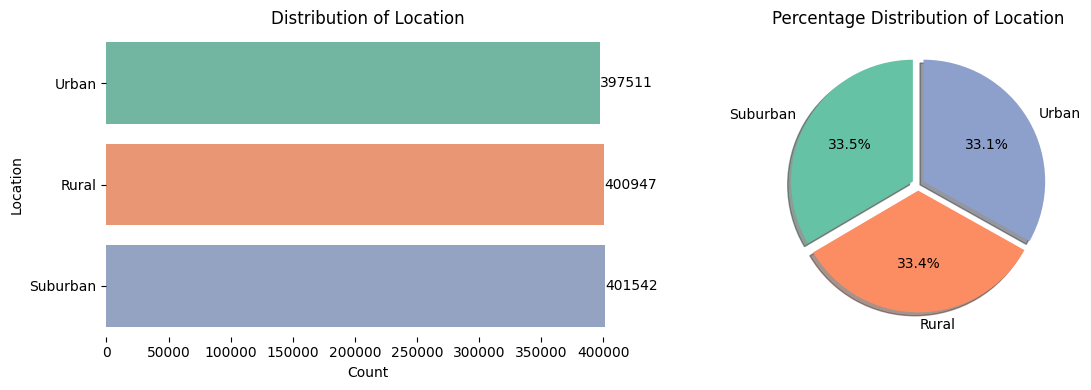

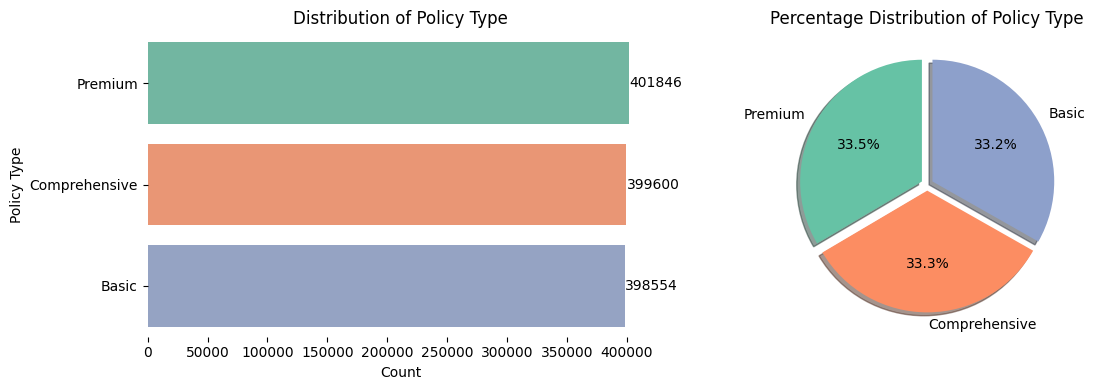

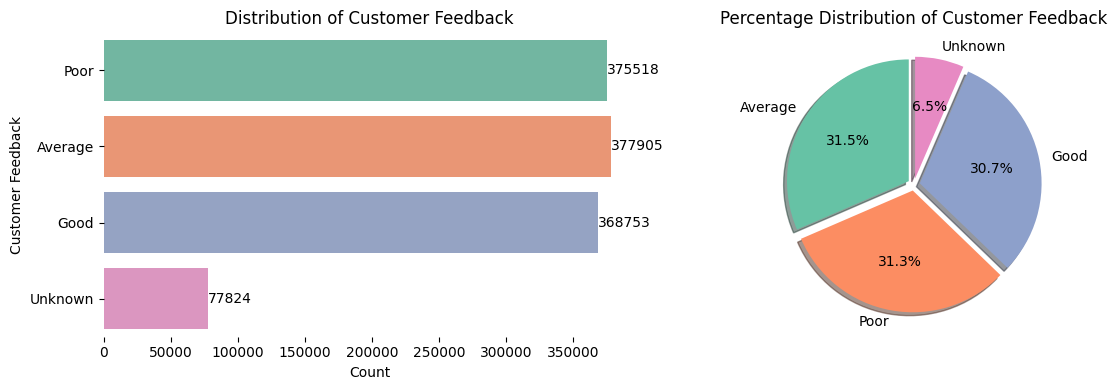

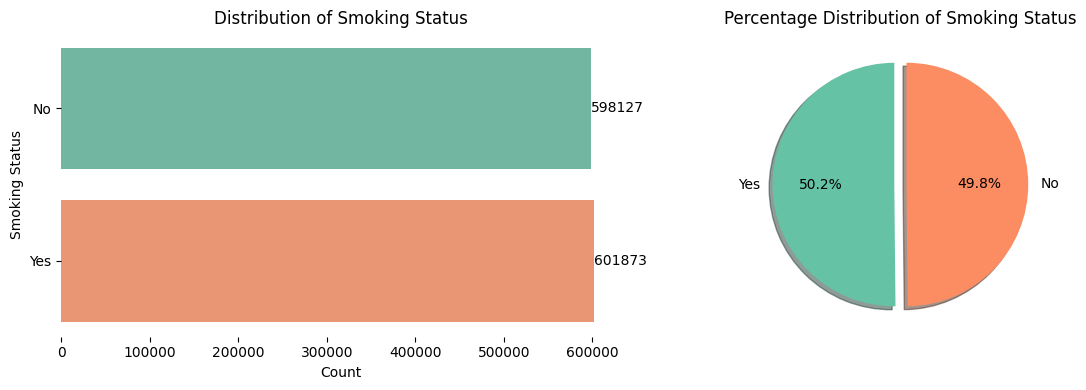

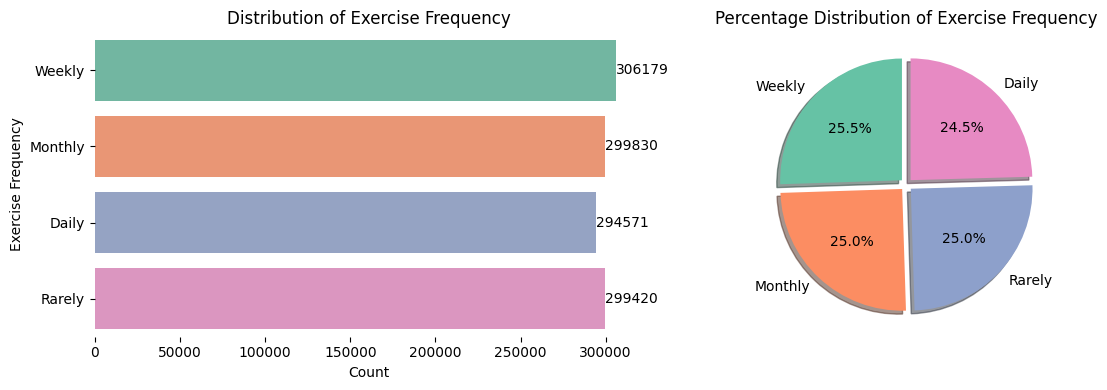

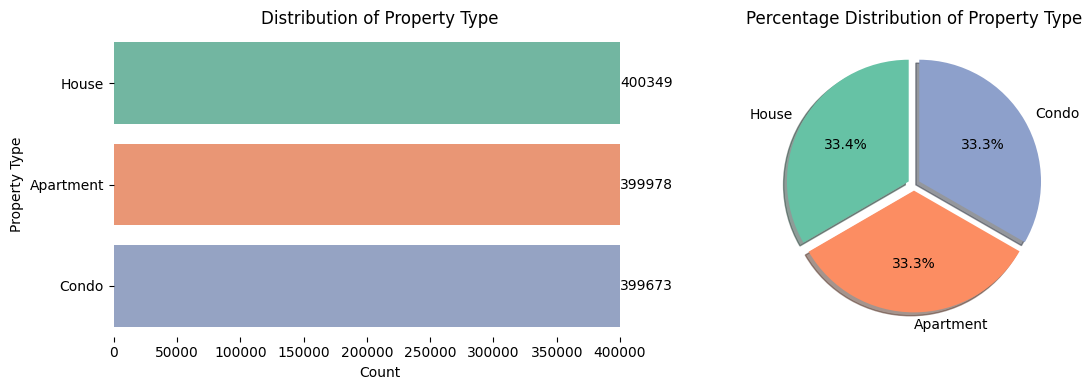

In [18]:
# Function to display barplot and pie chart for categorical columns
def plot_categorical_distribution(data, column_name):
    plt.figure(figsize=(12, 4))
    
    # Bar plot for categorical distribution
    plt.subplot(1, 2, 1)
    sns.countplot(y=column_name, data=data, palette='Set2', hue=column_name, legend=False)
    plt.title(f'Distribution of {column_name}', fontsize=12)
    plt.xlabel('Count', fontsize=10)
    plt.ylabel(column_name, fontsize=10)

    ax = plt.gca()
    for p in ax.patches:
        count = int(p.get_width())
        ax.annotate(f'{count}', 
                    (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), 
                    ha='left', va='center', fontsize=10, color='black')
    
    sns.despine(left=True, bottom=True)
    
    # Pie chart for percentage distribution
    plt.subplot(1, 2, 2)
    data[column_name].value_counts().plot.pie(
        autopct='%1.1f%%', 
        colors=sns.color_palette('Set2', data[column_name].nunique()), 
        startangle=90, 
        explode=[0.05] * data[column_name].nunique(), 
        shadow=True
    )
    plt.title(f'Percentage Distribution of {column_name}', fontsize=12)
    plt.ylabel('')  

    plt.tight_layout()
    plt.show()

categorical_columns = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 
                'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

for column in categorical_columns:
    plot_categorical_distribution(train, column)

In [19]:
# Function to calculate count and percentage of unique values
def unique_values_table(data, categorical_columns):
    results = {}
    for column in categorical_columns:
        value_counts = data[column].value_counts()
        percentages = (value_counts / len(data)) * 100
        results[column] = pd.DataFrame({
            'Value': value_counts.index,
            'Count': value_counts.values,
            'Percentage (%)': percentages.values
        })
    return results

# Specify categorical columns
categorical_columns = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 
                       'Policy Type', 'Customer Feedback', 'Smoking Status', 
                       'Exercise Frequency', 'Property Type']

# Get unique value tables for each categorical column
unique_values_results = unique_values_table(train, categorical_columns)

for column in categorical_columns[:10]:  
    print(f"Unique Values for {column}:\n")
    display(unique_values_results[column])

Unique Values for Gender:



,Value,Count,Percentage (%)
0,Male,602571,50.21425
1,Female,597429,49.78575


Unique Values for Marital Status:



,Value,Count,Percentage (%)
0,Single,395391,32.949250
1,Married,394316,32.859667
2,Divorced,391764,32.647000
3,Unknown,18529,1.544083


Unique Values for Education Level:



,Value,Count,Percentage (%)
0,Master's,303818,25.318167
1,PhD,303507,25.292250
2,Bachelor's,303234,25.269500
3,High School,289441,24.120083


Unique Values for Occupation:



,Value,Count,Percentage (%)
0,Unknown,358075,29.839583
1,Employed,282750,23.562500
2,Self-Employed,282645,23.553750
3,Unemployed,276530,23.044167


Unique Values for Location:



,Value,Count,Percentage (%)
0,Suburban,401542,33.461833
1,Rural,400947,33.412250
2,Urban,397511,33.125917


Unique Values for Policy Type:



,Value,Count,Percentage (%)
0,Premium,401846,33.487167
1,Comprehensive,399600,33.300000
2,Basic,398554,33.212833


Unique Values for Customer Feedback:



,Value,Count,Percentage (%)
0,Average,377905,31.492083
1,Poor,375518,31.293167
2,Good,368753,30.729417
3,Unknown,77824,6.485333


Unique Values for Smoking Status:



,Value,Count,Percentage (%)
0,Yes,601873,50.156083
1,No,598127,49.843917


Unique Values for Exercise Frequency:



,Value,Count,Percentage (%)
0,Weekly,306179,25.514917
1,Monthly,299830,24.985833
2,Rarely,299420,24.951667
3,Daily,294571,24.547583


Unique Values for Property Type:



,Value,Count,Percentage (%)
0,House,400349,33.362417
1,Apartment,399978,33.331500
2,Condo,399673,33.306083


Observational Insights:

    Gender Distribution:
        The dataset is balanced with a nearly equal proportion of males (50.21%) and females (49.79%).

    Marital Status:
        The three primary categories (Single, Married, Divorced) are distributed almost equally, each accounting for about 33%.
        A small percentage (1.54%) of data is categorized as Unknown, which could be imputed or treated based on the analysis.

    Education Level:
        Education levels are uniformly distributed among Bachelor's, Master's, PhD, and High School, with percentages ranging from 24% to 25%.
        No major outlier category exists in education, making this feature consistent.

    Occupation:
        A significant portion (29.84%) of data falls under the Unknown category, indicating missing values that were replaced during preprocessing.
        The remaining categories (Employed, Self-Employed, Unemployed) are evenly distributed around 23%.

    Location:
        The dataset shows an almost equal split between Suburban, Rural, and Urban areas, each contributing about 33% of the data.

    Policy Type:
        The types of policies (Premium, Comprehensive, Basic) are evenly distributed, with each type accounting for approximately one-third of the data.

    Customer Feedback:
        Feedback categories (Average, Poor, Good) account for around 31% each, with an Unknown category representing 6.48%.
        The presence of Unknown suggests gaps in feedback collection that might need attention.

    Smoking Status:
        A balanced distribution exists between Yes (50.16%) and No (49.84%) categories, making it a useful feature for potential analysis.

    Exercise Frequency:
        The dataset is evenly split across all four categories (Weekly, Monthly, Rarely, Daily), each contributing about 25%.

    Property Type:
        The three property types (House, Apartment, Condo) are evenly distributed, each accounting for approximately 33%.


Key Observations:

    Many categorical features have balanced distributions, which can be advantageous for model training as it reduces bias.
    Certain features, such as Occupation, Customer Feedback, and Marital Status, contain Unknown categories due to imputed missing values. Their treatment depends on the modeling approach.
    Most features exhibit uniform distribution across their categories, suggesting no dominance of a single class, which could enhance feature diversity in the model.



Summary Statistics for Premium Amount by Gender:
               mean  median   count
Gender                             
Female  1102.404974   872.0  597429
Male    1102.683476   872.0  602571


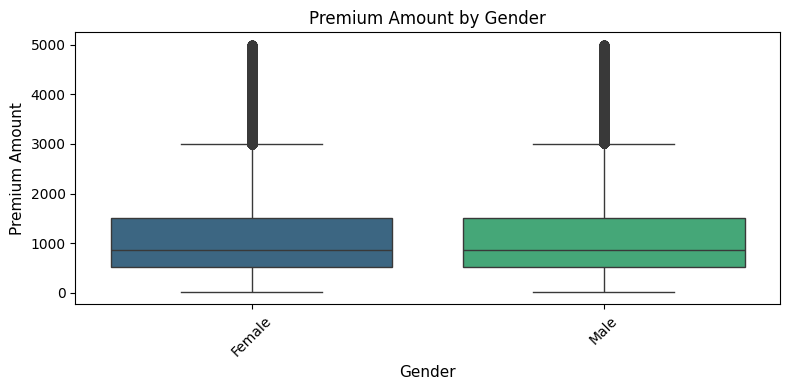


Summary Statistics for Premium Amount by Marital Status:
                       mean  median   count
Marital Status                             
Divorced        1100.625116   870.0  391764
Married         1099.844389   870.0  394316
Single          1101.735535   872.0  395391
Unknown         1217.871067  1001.0   18529


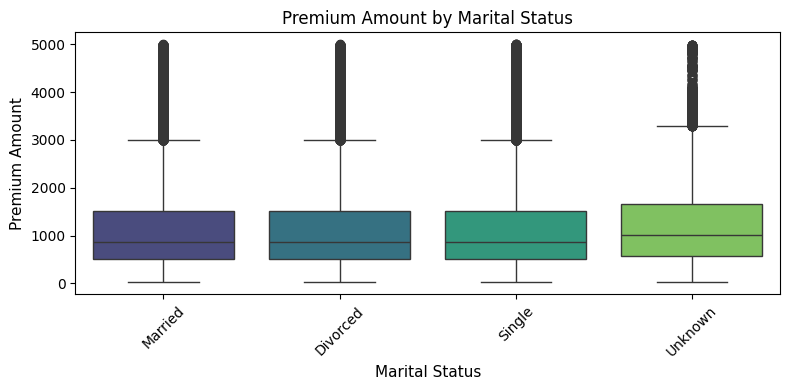


Summary Statistics for Premium Amount by Education Level:
                        mean  median   count
Education Level                             
Bachelor's       1102.698438   873.0  303234
High School      1104.787490   876.0  289441
Master's         1102.113989   871.0  303818
PhD              1100.683885   869.0  303507


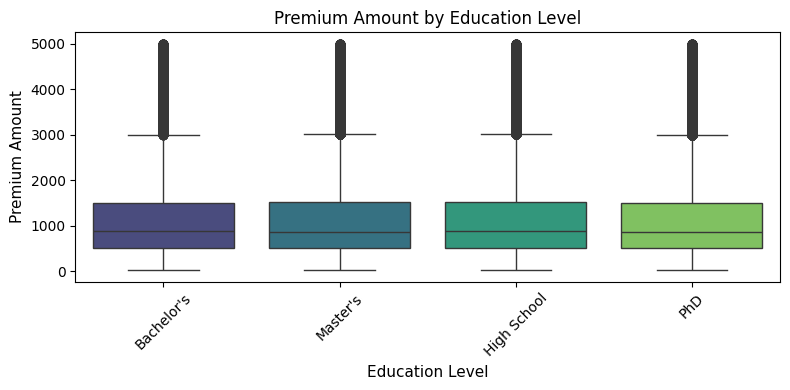


Summary Statistics for Premium Amount by Occupation:
                      mean  median   count
Occupation                                
Employed       1107.400895   881.0  282750
Self-Employed  1106.609284   874.0  282645
Unemployed     1105.369023   874.0  276530
Unknown        1093.320969   861.0  358075


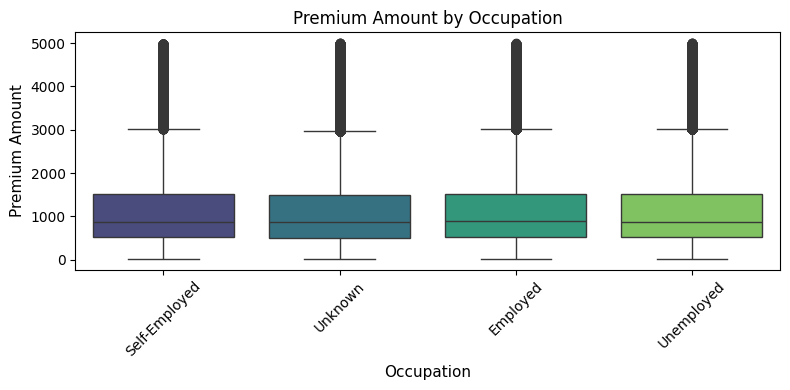


Summary Statistics for Premium Amount by Location:
                 mean  median   count
Location                             
Rural     1101.467665   871.0  400947
Suburban  1102.462014   871.0  401542
Urban     1103.714936   874.0  397511


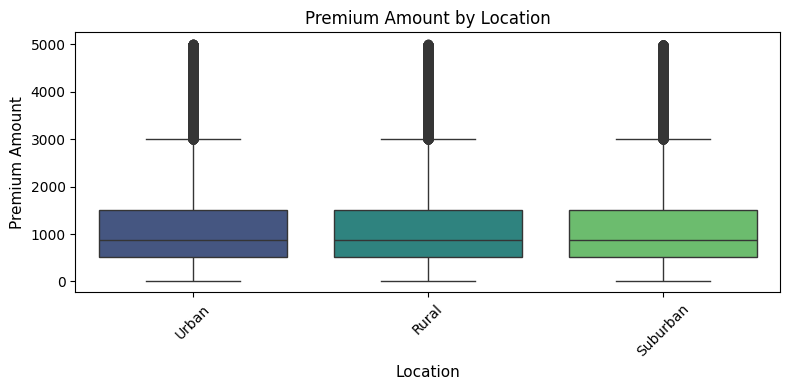


Summary Statistics for Premium Amount by Policy Type:
                      mean  median   count
Policy Type                               
Basic          1103.452466   874.0  398554
Comprehensive  1102.610526   873.0  399600
Premium        1101.579277   870.0  401846


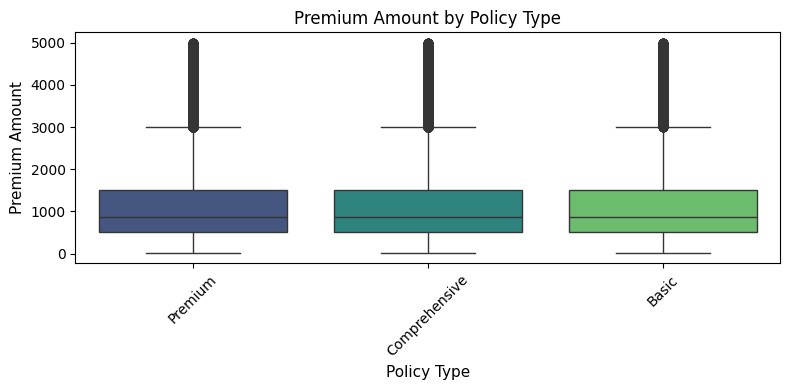


Summary Statistics for Premium Amount by Customer Feedback:
                          mean  median   count
Customer Feedback                             
Average            1094.350977   861.0  377905
Good               1096.284299   861.0  368753
Poor               1098.892745   868.0  375518
Unknown            1189.619526   956.0   77824


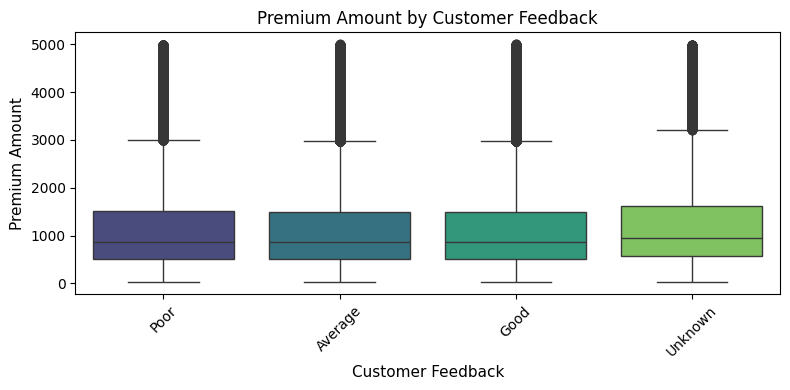


Summary Statistics for Premium Amount by Smoking Status:
                       mean  median   count
Smoking Status                             
No              1102.403607   872.0  598127
Yes             1102.685158   872.0  601873


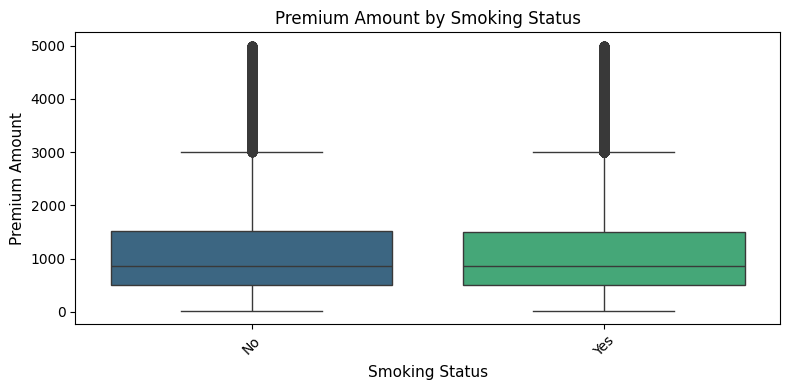


Summary Statistics for Premium Amount by Exercise Frequency:
                           mean  median   count
Exercise Frequency                             
Daily               1103.789093   874.0  294571
Monthly             1103.011720   871.0  299830
Rarely              1102.193317   871.0  299420
Weekly              1101.234252   872.0  306179


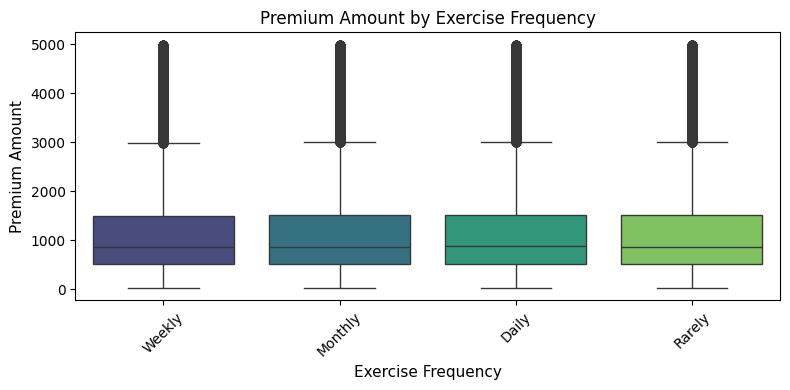


Summary Statistics for Premium Amount by Property Type:
                      mean  median   count
Property Type                             
Apartment      1104.150596   872.0  399978
Condo          1101.922627   871.0  399673
House          1101.561680   873.0  400349


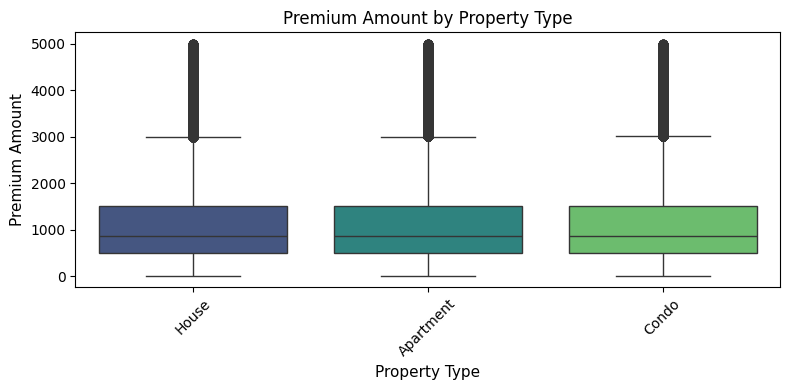

In [20]:
# List of categorical columns
categorical_columns = [
    'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 
    'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type'
]

# Loop through each categorical feature to display summary statistics and box plot
for column in categorical_columns:
    # Calculate summary statistics grouped by the categorical column
    stats = train.groupby(column)['Premium Amount'].agg(['mean', 'median', 'count'])
    
    # Display summary statistics
    print(f"\nSummary Statistics for Premium Amount by {column}:")
    print(stats)
    
    # Plot box plot
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=train, x=column, y='Premium Amount', palette='viridis', hue=column, legend=False)
    plt.title(f'Premium Amount by {column}', fontsize=12)
    plt.xlabel(column, fontsize=11)
    plt.ylabel('Premium Amount', fontsize=11)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Data Preprocessing


### Converting Date Columns to Epoch Time

In [21]:
# Retrieve columns with 'object' data type
datetime_columns = train.select_dtypes(include=['object']).columns

for col in datetime_columns:
    try:
        # Convert the column to datetime format
        train[col] = pd.to_datetime(train[col], errors='raise')
        test[col] = pd.to_datetime(test[col], errors='raise')
        
        # Convert datetime to epoch time (in seconds)
        train[col] = train[col].astype(np.int64) / 10**9
        test[col] = test[col].astype(np.int64) / 10**9

        print(f"Converted '{col}' to epoch time.")
    except Exception as e:
        print(f"Skipping column '{col}' due to: {e}")

/tmp/ipykernel_469663/4132570654.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train[col] = pd.to_datetime(train[col], errors='raise')
/tmp/ipykernel_469663/4132570654.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train[col] = pd.to_datetime(train[col], errors='raise')
/tmp/ipykernel_469663/4132570654.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train[col] = pd.to_datetime(train[col], errors='raise')
/tmp/ipykernel_469663/4132570654.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensur

Skipping column 'Gender' due to: Unknown datetime string format, unable to parse: Female, at position 0
Skipping column 'Marital Status' due to: Unknown datetime string format, unable to parse: Married, at position 0
Skipping column 'Education Level' due to: Unknown datetime string format, unable to parse: Bachelor's, at position 0
Skipping column 'Occupation' due to: Unknown datetime string format, unable to parse: Self-Employed, at position 0
Skipping column 'Location' due to: Unknown datetime string format, unable to parse: Urban, at position 0
Skipping column 'Policy Type' due to: Unknown datetime string format, unable to parse: Premium, at position 0
Converted 'Policy Start Date' to epoch time.
Skipping column 'Customer Feedback' due to: Unknown datetime string format, unable to parse: Poor, at position 0
Skipping column 'Smoking Status' due to: Unknown datetime string format, unable to parse: No, at position 0
Skipping column 'Exercise Frequency' due to: Unknown datetime string f

/tmp/ipykernel_469663/4132570654.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train[col] = pd.to_datetime(train[col], errors='raise')
/tmp/ipykernel_469663/4132570654.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train[col] = pd.to_datetime(train[col], errors='raise')
/tmp/ipykernel_469663/4132570654.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train[col] = pd.to_datetime(train[col], errors='raise')
/tmp/ipykernel_469663/4132570654.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensur

In [22]:
# Check the first few rows and data type of the 'Policy Start Date' column
column_name = 'Policy Start Date'

# Display the first few rows
print(f"Sample data for '{column_name}':\n", train[column_name].head())

# Display the data type of the column
print(f"Data type of '{column_name}' in train_data: {train[column_name].dtype}")

# Repeat for test_data
print(f"Sample data for '{column_name}' in test_data:\n", test[column_name].head())
print(f"Data type of '{column_name}' in test_data: {test[column_name].dtype}")

Sample data for 'Policy Start Date':
 id
0    1.703345e+09
1    1.686583e+09
2    1.696087e+09
3    1.718206e+09
4    1.638372e+09
Name: Policy Start Date, dtype: float64
Data type of 'Policy Start Date' in train_data: float64
Sample data for 'Policy Start Date' in test_data:
 id
1200000    1.685892e+09
1200001    1.713799e+09
1200002    1.680708e+09
1200003    1.698247e+09
1200004    1.637940e+09
Name: Policy Start Date, dtype: float64
Data type of 'Policy Start Date' in test_data: float64




    Successfully converts the 'Policy Start Date' column to datetime and then to epoch time.
    The converted Policy Start Date values (e.g., 1.703345e+09) are epoch times in seconds.
    The float64 data type indicates that the values are now numerical.



### Label Encoding Categorical Features

In [23]:
def identify_non_numerical_features(data, dataset_name):
    non_numerical_features = data.select_dtypes(include=['object'])
    print(f"Non-Numerical Features and Unique Values in {dataset_name} dataset:")
    for column in non_numerical_features.columns:
        unique_values = non_numerical_features[column].unique()
        print(f"\n{column}: {unique_values}")

# Apply the function to training and test datasets
identify_non_numerical_features(train, "Training")
print("\n")
identify_non_numerical_features(test, "Test")

Non-Numerical Features and Unique Values in Training dataset:

Gender: ['Female' 'Male']

Marital Status: ['Married' 'Divorced' 'Single' 'Unknown']

Education Level: ["Bachelor's" "Master's" 'High School' 'PhD']

Occupation: ['Self-Employed' 'Unknown' 'Employed' 'Unemployed']

Location: ['Urban' 'Rural' 'Suburban']

Policy Type: ['Premium' 'Comprehensive' 'Basic']

Customer Feedback: ['Poor' 'Average' 'Good' 'Unknown']

Smoking Status: ['No' 'Yes']

Exercise Frequency: ['Weekly' 'Monthly' 'Daily' 'Rarely']

Property Type: ['House' 'Apartment' 'Condo']


Non-Numerical Features and Unique Values in Test dataset:

Gender: ['Female' 'Male']

Marital Status: ['Unknown' 'Married' 'Divorced' 'Single']

Education Level: ["Bachelor's" "Master's" 'PhD' 'High School']

Occupation: ['Self-Employed' 'Unemployed' 'Unknown' 'Employed']

Location: ['Rural' 'Suburban' 'Urban']

Policy Type: ['Basic' 'Premium' 'Comprehensive']

Customer Feedback: ['Poor' 'Good' 'Average' 'Unknown']

Smoking Status: ['Ye

In [59]:
# Define the encoding strategies for specific features
binary_features = ['Gender', 'Smoking Status']
ordinal_features = {
    'Exercise Frequency': ['Rarely', 'Monthly', 'Weekly', 'Daily']
}
nominal_features = ['Marital Status', 'Education Level', 'Occupation', 
                    'Location', 'Policy Type', 'Customer Feedback', 'Property Type']

# Binary Encoding for binary features
le = LabelEncoder()
for feature in binary_features:
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.transform(test[feature])

# Ordinal Encoding for ordered features
for feature, order in ordinal_features.items():
    oe = OrdinalEncoder(categories=[order],dtype=np.str_)
    train[feature] = oe.fit_transform(train[[feature]]).flatten()  # Flatten to 1D
    test[feature] = oe.transform(test[[feature]]).flatten()       # Flatten to 1D

# One-Hot Encoding for nominal features
train_data = pd.get_dummies(train, columns=nominal_features, drop_first=True)
test_data = pd.get_dummies(test, columns=nominal_features, drop_first=True)

ValueError: Found unknown categories ['3', '1', '2', '0'] in column 0 during fit

#### Verifying Data Types Across Datasets

In [25]:
# Create data type tables for train_data and test_data
train_data_types = pd.DataFrame({
    'Column Name': train_data.columns,
    'Train Data Type': train_data.dtypes
})

test_data_types = pd.DataFrame({
    'Column Name': test_data.columns,
    'Test Data Type': test_data.dtypes
})

# Merge the two tables for comparison
data_types_comparison = pd.merge(
    train_data_types, 
    test_data_types, 
    on='Column Name', 
    how='outer'
)

# Display the data types comparison table
print("Data Types Comparison of Train and Test Datasets:\n")
display(data_types_comparison)

Data Types Comparison of Train and Test Datasets:



,Column Name,Train Data Type,Test Data Type
0,Age,float64,float64
1,Annual Income,float64,float64
2,Credit Score,float64,float64
3,Customer Feedback_Good,bool,bool
4,Customer Feedback_Poor,bool,bool
5,Customer Feedback_Unknown,bool,bool
6,Education Level_High School,bool,bool
7,Education Level_Master's,bool,bool
8,Education Level_PhD,bool,bool
9,Exercise Frequency,object,object


### Normalization of Numerical Features 

In [26]:
# Select numerical columns
numerical_columns = train_data.select_dtypes(include=['float64']).columns
numerical_columns = numerical_columns[numerical_columns != target_column]

# Applying Normalization
scaler = StandardScaler()
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])



    The StandardScaler is used to standardize numerical features by removing the mean and scaling to unit variance.
    The scaler is fit on the train_data to calculate the mean and standard deviation and then applied to both train_data and test_data.

Why This Step is Important:

    Normalization ensures that all numerical features contribute equally to the model, preventing features with larger magnitudes (e.g., Annual Income) from dominating those with smaller values (e.g., Vehicle Age).



### Distribution Analysis of Preprocessed Features

/tmp/ipykernel_469663/832263378.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap('viridis', len(numeric_columns))


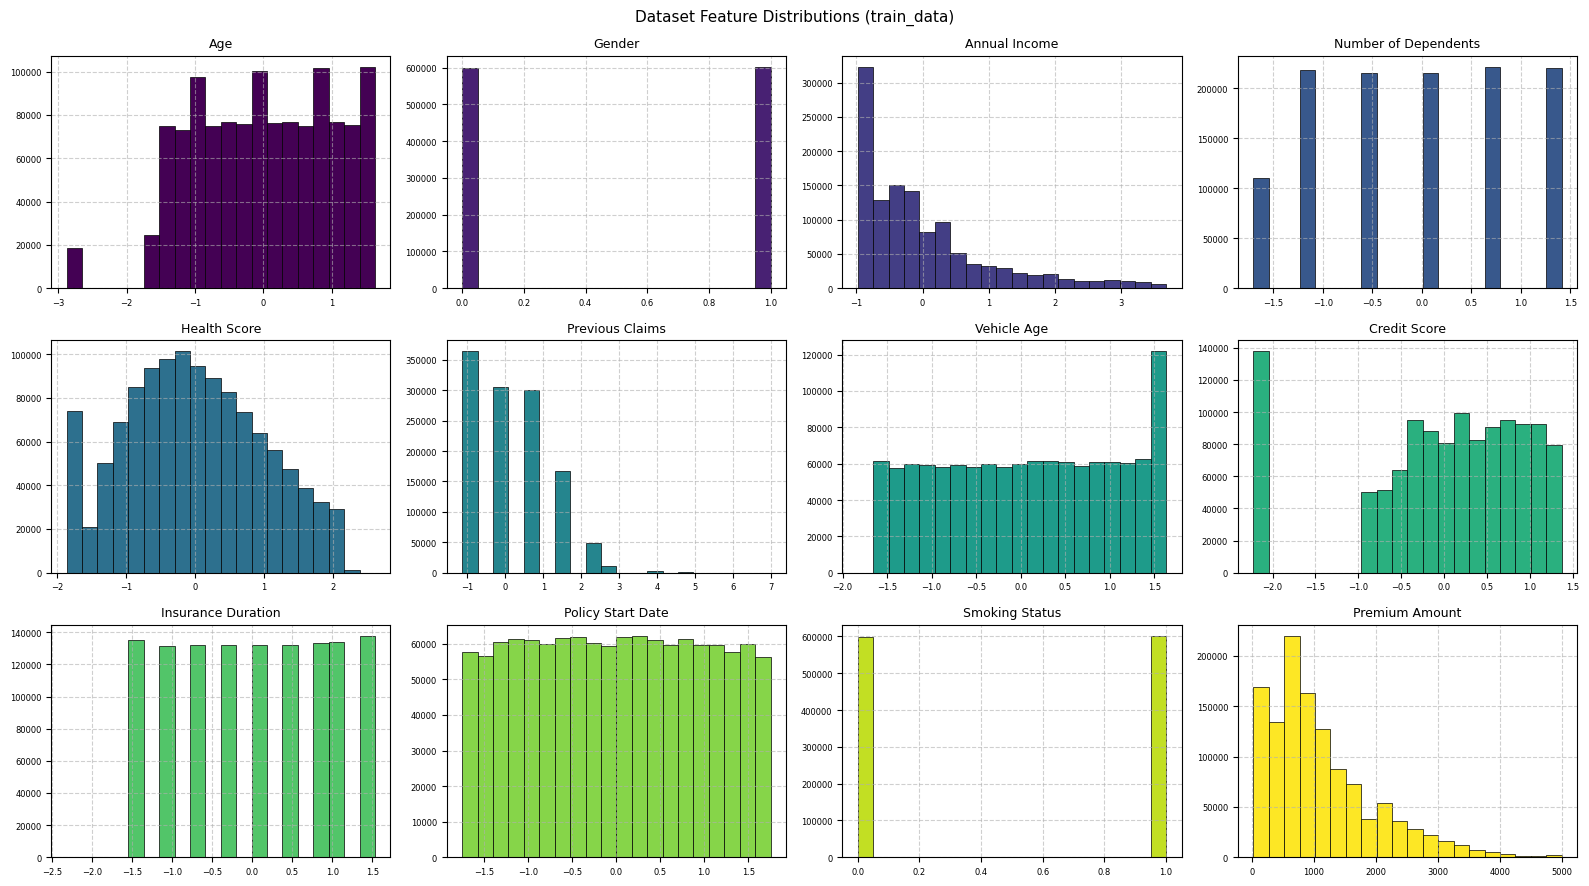

In [27]:
# Identify numeric columns only (excluding boolean columns)
numeric_columns = train_data.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns needed
num_features = len(numeric_columns)
num_cols = 4
num_rows = math.ceil(num_features / num_cols)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, num_rows * 3))
viridis_cmap = cm.get_cmap('viridis', len(numeric_columns))

# Plot each numeric column
for i, column in enumerate(numeric_columns):
    ax = axes.flatten()[i]
    train_data[column].hist(
        ax=ax, 
        bins=20, 
        color=viridis_cmap(i / len(numeric_columns)),  
        edgecolor='black', 
        linewidth=0.5
    )
    ax.set_title(column, fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid(True, linestyle='--', alpha=0.6)  

# Remove empty subplots if any
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.suptitle('Dataset Feature Distributions (train_data)', fontsize=11)
plt.tight_layout()
plt.show()

### Skewness Reduction with Log Transformation

In [28]:
# Define the continuous columns
continuous_columns_train = ['Annual Income', 'Premium Amount']  
continuous_columns_test = ['Annual Income']  

# Calculate skewness for the specified continuous columns
train_skewness = train_data[continuous_columns_train].apply(skew)
test_skewness = test_data[continuous_columns_test].apply(skew)

# Display results
print("Skewness for Training Dataset:\n")
display(train_skewness)

print("\nSkewness for Test Dataset:\n")
display(test_skewness)

Skewness for Training Dataset:



Annual Income     1.490474
Premium Amount    1.240914
dtype: float64


Skewness for Test Dataset:



Annual Income    1.484572
dtype: float64

In [29]:
# Log-transform skewed features
train_data['Annual Income'] = np.log1p(train_data['Annual Income'])
test_data['Annual Income'] = np.log1p(test_data['Annual Income'])

In [30]:
# Select only numeric columns from the training data
numeric_data = train_data.select_dtypes(include=['number'])

# Add a new column for the log-transformed values of target variable
numeric_data['Log_Transformed_Premium'] = np.log1p(train_data[target_column])


Explanation and Insights:
Skewness Analysis:

    Training Dataset Skewness:
        Annual Income: A skewness value of 1.522952 indicates moderate positive skewness, meaning that the distribution is tailing to the right, with a significant number of smaller income values and fewer larger ones.
        Premium Amount: A skewness value of 1.240914 also shows positive skewness, indicating that most premium values are clustered at the lower range with fewer higher premiums.

    Test Dataset Skewness:
        Annual Income: The skewness value of 1.516915 mirrors the training data, confirming that both datasets share similar distributions for this feature.

Log Transformation:

    Applying a log transformation to Annual Income reduces its skewness and compresses the range of larger values. This step makes the distribution closer to normal, benefiting algorithms sensitive to skewed data.

Adding Log of Target (Log_Transformed_Premium):

    The addition of a Log_Transformed_Premium column in the training dataset creates a normalized target variable that minimizes the impact of extreme outliers, leading to better model performance.



### Correlation Analysis of Preprocessed Data

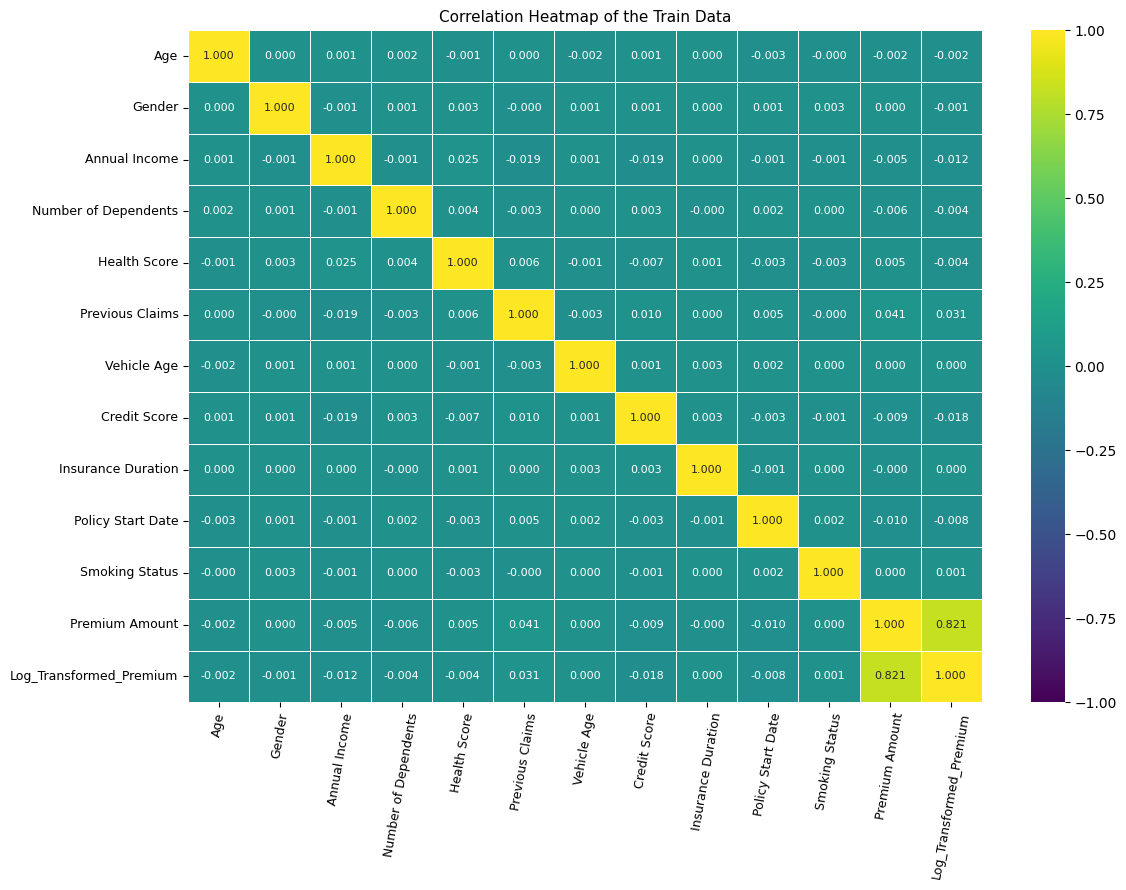

In [31]:
# Compute the correlation matrix
train_corr_matrix = numeric_data.corr()

# Create the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(
    train_corr_matrix, 
    annot=True, 
    cmap='viridis',   
    vmax=1, 
    vmin=-1,
    annot_kws={"size": 8}, 
    fmt=".3f",
    linewidths=0.5  
)

# Customize x and y tick labels
plt.xticks(rotation=80, fontsize=9)
plt.yticks(fontsize=9)

# Add title and layout adjustments
plt.title("Correlation Heatmap of the Train Data", fontsize=11)
plt.tight_layout()
plt.show()


Difference Between Premium Amount and Log_Transformed_Premium with Other Features:¶

    Correlation Strength:
        The correlation between Log_Transformed_Premium and other features tends to be slightly weaker compared to the correlation of the original Premium Amount with the same features. This is because the log transformation compresses the range of the Premium Amount, reducing the influence of extreme values (outliers).

    Normalization of Relationships:
        The log-transformed Log_Transformed_Premium shows more stable and normalized relationships with features like Health Score and Customer Feedback, which might indicate that these relationships are nonlinear in the raw Premium Amount.

    Reduction in Skewness Impact:
        In features like Annual Income, where the original correlation with Premium Amount is mildly negative, the correlation with Log_Transformed_Premium is further reduced. This suggests that the transformation reduces the skewed influence of high Premium Amount values.

    Stronger Predictive Relationships:
        The correlation between Log_Transformed_Premium and the original target (Premium Amount) is very high, indicating that the transformation retains most of the predictive information. However, the log-transformed target smooths out extreme values and better aligns with features like Health Score and Previous Claims.

    Impact of High-Variance Features:
        Features with high variability, such as Credit Score or Annual Income, exhibit more stable correlations with Log_Transformed_Premium, making them potentially more predictable in models using the transformed target.

    Feature Contribution Differences:
        The relationship between categorical features (e.g., Location, Policy Type) and the target remains nearly the same for Premium Amount and Log_Transformed_Premium, indicating that these features are less influenced by the target transformation.

    Higher Correlation with Log_Transformed_Premium for Log-Normal Relationships:
        Features like Health Score and Policy Start Date show slightly stronger positive correlations with Log_Transformed_Premium compared to Premium Amount, suggesting that these features have log-normal relationships with the target.

Key Observations:

    The log-transformation of the target variable (Log_Transformed_Premium) smooths the relationships between the target and input features, particularly for features influenced by outliers (e.g., Annual Income and Previous Claims).
    It reduces the magnitude of extreme correlations, creating a more stable predictive target while retaining the most critical relationships for predictive modeling.
    Features showing slight differences in correlation strength post-transformation indicate the utility of Log_Transformed_Premium for handling nonlinear relationships effectively.



### Separating Features and Target

In [32]:
# Separate Features and Target
X_train = train_data.drop([target_column], axis=1)  # Features
y_train = train_data[target_column] 

### Applying Log Transformation to the target variable

In [33]:
# Apply log transformation to the target variable
y_train_log = np.log1p(y_train)  # log1p is used for log(1 + x)

/tmp/ipykernel_469663/3055905589.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap("viridis")


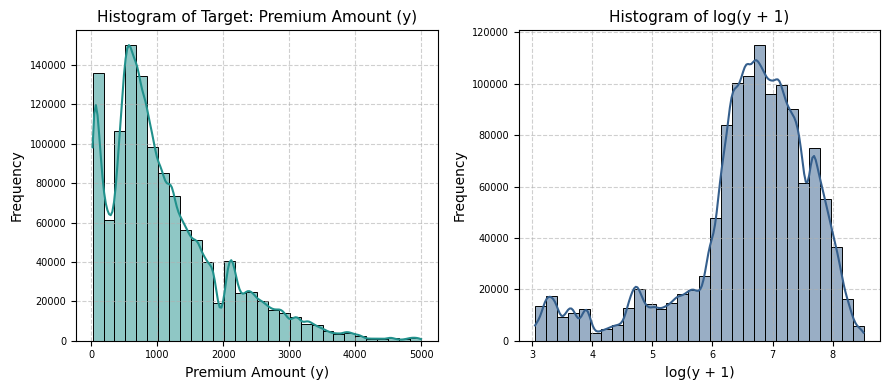

In [34]:
# Custom colormap using viridis
viridis_cmap = cm.get_cmap("viridis")

# Select two colors from the colormap
color1 = viridis_cmap(0.5)  
color2 = viridis_cmap(0.3)  

# Plot with the custom colors
plt.figure(figsize=(9, 4))

# Plot original target distribution
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, bins=30, color=color1)
plt.title(f'Histogram of Target: {target_column} (y)', fontsize=11)
plt.xlabel(f'{target_column} (y)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.grid(True, linestyle='--', alpha=0.6)

# Log-transformed target distribution
plt.subplot(1, 2, 2)
sns.histplot(y_train_log, kde=True, bins=30, color=color2)
plt.title('Histogram of log(y + 1)', fontsize=11)
plt.xlabel('log(y + 1)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Histogram of log(y + 1)

    Transformed Distribution:
        After applying the logarithmic transformation (log(y + 1)), the distribution becomes approximately normal, reducing the skewness observed in the original data.
        This normalization ensures that most values fall within a manageable range for machine learning models, improving their performance.

    Symmetry and Centralization:
        The log transformation centers the distribution, with a peak around the range of log(y + 1) values between 6 and 7.

By compressing the scale of high premium values, the transformation mitigates the influence of outliers, reducing their weight in model training. A normal-like distribution aligns better with assumptions made by many regression models, potentially leading to more accurate predictions.


In [35]:
# Remove whitespaces in feature names for X_train and test_data
X_train.columns = X_train.columns.str.replace(' ', '_', regex=True)
test_data.columns = test_data.columns.str.replace(' ', '_', regex=True)

# Verify the updated column names
print("Updated Feature Names in X_train:")
print(X_train.columns)

print("\nUpdated Feature Names in test_data:")
print(test_data.columns)

Updated Feature Names in X_train:
Index(['Age', 'Gender', 'Annual_Income', 'Number_of_Dependents',
       'Health_Score', 'Previous_Claims', 'Vehicle_Age', 'Credit_Score',
       'Insurance_Duration', 'Policy_Start_Date', 'Smoking_Status',
       'Exercise_Frequency', 'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Education_Level_High_School',
       'Education_Level_Master's', 'Education_Level_PhD',
       'Occupation_Self-Employed', 'Occupation_Unemployed',
       'Occupation_Unknown', 'Location_Suburban', 'Location_Urban',
       'Policy_Type_Comprehensive', 'Policy_Type_Premium',
       'Customer_Feedback_Good', 'Customer_Feedback_Poor',
       'Customer_Feedback_Unknown', 'Property_Type_Condo',
       'Property_Type_House'],
      dtype='object')

Updated Feature Names in test_data:
Index(['Age', 'Gender', 'Annual_Income', 'Number_of_Dependents',
       'Health_Score', 'Previous_Claims', 'Vehicle_Age', 'Credit_Score',
       'Insurance_Duratio

In [57]:
# Display data types
print("Feature Data Types (X_train):")
print(X_train.dtypes)

print("\nTarget Data Type (y_train):")
print(y_train.dtypes)

print("\nLog-Transformed Target Data Type (y_train_log):")
print(y_train_log.dtypes)

Feature Data Types (X_train):
Age                            float64
Gender                           int64
Annual_Income                  float64
Number_of_Dependents           float64
Health_Score                   float64
Previous_Claims                float64
Vehicle_Age                    float64
Credit_Score                   float64
Insurance_Duration             float64
Policy_Start_Date              float64
Smoking_Status                   int64
Exercise_Frequency              object
Marital_Status_Married            bool
Marital_Status_Single             bool
Marital_Status_Unknown            bool
Education_Level_High_School       bool
Education_Level_Master's          bool
Education_Level_PhD               bool
Occupation_Self-Employed          bool
Occupation_Unemployed             bool
Occupation_Unknown                bool
Location_Suburban                 bool
Location_Urban                    bool
Policy_Type_Comprehensive         bool
Policy_Type_Premium               

## Model Training 

In [37]:
X_all, y_all = X_train, y_train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [38]:
from sklearn import linear_model

In [39]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_valid, y_valid)

0.0027604750967380465

In [40]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(X_train, y_train)

RandomForestRegressor()

In [41]:
forest.score(X_valid, y_valid)

0.044770283191826965

In [43]:
ridge = linear_model.Ridge(alpha=.5)
ridge.fit(X_train, y_train)

Ridge(alpha=0.5)

In [44]:
ridge.score(X_valid, y_valid)

0.0027604764356882194

In [45]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [46]:
lasso.score(X_valid, y_valid)

0.002774162924478296

In [48]:
test_predictions = forest.predict(test_data)

In [49]:
submission = pd.DataFrame({"id": test_data.index, target_column: test_predictions})
submission.to_csv("ensemble_oof_submission.csv", index=False)